In [1]:
from collections import defaultdict
import networkx as nx
import numpy as np
import pandas as pd
import re
import sys, os



#current_dir = os.getcwd()
current_dir ="/Users/cdonnat/Dropbox/DDI/"
sys.path.append(current_dir)
from parse_functions import *

NAME_FILE = "/Users/cdonnat/Downloads/full database.xml"



file1 = open(NAME_FILE, "r")
str1=file1.read()
file1.close()
list1= str1.replace("\n", " ").split('drug type')

##### Process the data


In [30]:
# import pickle
# with open('/Users/cdonnat/Downloads/drug_data.pkl', 'rb') as f:
#     dictionary = pickle.load( f)

In [14]:
from datetime import datetime
import numpy as np
import re



def parse_agent(c):
    id_c = re.findall(r'<id>(.*?)<\/id>', c)[0] if len(re.findall(r'<id>(.*?)<\/id>', c))>0 else ""
    identifier= re.findall(r'<identifier>(.*?)<\/identifier>', c)[0] if len(re.findall(r'<identifier>(.*?)<\/identifier>', c))>0 else ""
    poly_id = re.findall(r'<polypeptide id=\"(.*?)\"', c)[0] if len(re.findall(r'<polypeptide id=\"(.*?)\"', c))>0 else ""
    synonyms = re.findall(r'<synonym>(.*?)<\/synonym>', c)
    if len(synonyms) == 0: synonyms =[]
    name = re.findall(r'<name>(.*?)<\/name>', c)[0] if len(re.findall(r'<name>(.*?)<\/name>', c))>0 else ""
    action = re.findall(r'<action>(.*?)<\/action>', c)
    if len(action) == 0: action =[]
    pfams = re.findall(r'<identifier>(.*?)<\/identifier>', c)
    if len(pfams) == 0: pfams =[]
    go_classifiers = re.findall(r'<go-classifier>(.*?)<\/go-classifier>', c)
    if len(go_classifiers) == 0: go_classifiers =[]
    cellular_location = re.findall(r"<cellular-location>(.*?)<\/cellular-location>", c)
    if len(cellular_location) == 0: cellular_location =[]
    return(poly_id, {'name':name, 'id': id_c,
            'identifier': identifier,
            'cellular_location' : cellular_location,
            'action': action,
            'pfam': pfams,
            'synonyms': synonyms,
            'go-classifier': [[re.findall(r"<category>(.*?)<\/category>", p)[0], re.findall(r"<description>(.*?)<\/description>", p)[0]]
                    for p in go_classifiers]
                        })

def parse_classification(classification):
    pattern = r"<direct-parent>(.*?)<\/direct-parent>"
    direct_parent=re.findall(pattern, classification)
    if len(direct_parent) == 0:
        res = {'direct-parent' : 'None'}
    else:
        res = {'direct-parent' : direct_parent[0]}

    pattern = r"<kingdom>(.*?)<\/kingdom>"
    kingdom = re.findall(pattern, classification)
    if len(kingdom) == 0:
        res['kingdom'] = 'None'
    else:
        res['kingdom'] = kingdom[0]

    pattern = r"<superclass>(.*?)<\/superclass>"
    superclass = re.findall(pattern, classification)
    if len(superclass) == 0:
        res['superclass'] = 'None'
    else:
        res['superclass'] = superclass[0]

    pattern=r"<class>(.*?)<\/class>"
    Class=re.findall(pattern, classification)
    if len(Class)==0:
        res['class'] = 'None'
    else:
        res['class'] = Class[0]

    pattern=r"<subclass>(.*?)<\/subclass>"
    subclass=re.findall(pattern, classification)
    if len(subclass)==0:
        res['subclass'] = 'None'
    else:
        res['subclass'] = subclass[0]
    return(res)

def parse_pathways(pathlist):
    out = {}
    if len(pathlist) > 0:
        for j in range(len(pathlist)):
            index = 'pathways'+str(j+1)
            #pattern = r"<pathway>(.*)<ds>"
            path = pathlist[j]
            smpdb_id = re.findall(r"<smpdb-id>(.*)</smpdb-id>", path)[0] if len(re.findall(r"<smpdb-id>(.*)</smpdb-id>", path))>0 else ""
            namep = re.findall(r"<name>(.*?)<\/name>", str(path).replace('.', '. '))[0]
            category = re.findall(r"<category>(.*)</category>", str(path))[0] if len(re.findall(r"<category>(.*)</category>", path))>0 else ""
            pathways_details = {'smpdb_id':smpdb_id,
                                'name_pathway': namep,
                                'category_pathway' : category}

            pattern=r"<drug>(.*?) </drug>"
            druglist=re.findall(pattern, pathlist[j])
            if len(druglist)>0:
                drugs_in_pathway  = [re.findall(r"<drugbank-id>(.*)<\/drugbank-id>", d)[0] for d in druglist]
            pathways_details['drugs_in_pathway'] = drugs_in_pathway

            pattern="<enzymes>(.*)</enzymes>"
            enzyme_list = re.findall(pattern, pathlist[j])
            enzymes_in_pathway = []
            if len(enzyme_list)>0:
                enzymes_in_pathway = re.findall(r"<uniprot-id>(.*?)</uniprot-id>", enzyme_list[0])
            pathways_details['enzymes_in_pathway'] = enzymes_in_pathway
            out[index] = pathways_details
    return(out)

def parse_ddi(newlist):
    key = 1
    out = {}
    if len(newlist) > 0:
        for j in range(len(newlist)):
            index = 'drug_interaction' + str(key)
            pattern = r"<drugbank-id>(.*)<\/drugbank-id>"
            match = re.findall(pattern,newlist[j])
            drug_bank_id = match[0]
            pattern1 = r"<name>(.*)<\/name>"
            name1 = re.findall(pattern1,newlist[j])[0]
            pattern2 = r"<description>(.*)</description>"
            description1 = re.findall(pattern2,newlist[j])[0]
            out[drug_bank_id] = {'name':name1,
                                  'description': description1}
    return(out)


def parse_categories(x):
    cat_code  = re.findall(r"<categories>(.*)</categories>", x.lower())
    if len(cat_code)>0:
        all_cats = [[e[0], e[2]] for e in re.findall(r'<category>[ ]+<category>(.*?)<\/category>[ ]+(<mesh-id>|)(.*?)(<\/mesh-id>|<mesh-id\/>)[ ]+ <\/category>', cat_code[0])]
    else:
        all_cats = []
    return(all_cats)



def parse_atc_codes(x):
    atc_code  = re.findall(r"<atc-codes>(.*)</atc-codes>", x.lower())
    if len(atc_code)>0:
        code = re.findall(r'<atc-code code=\"(.*?)\">', atc_code[0])
        all_codes = re.findall(r'<level code=\"(.*?)\">(.*?)</level>', atc_code[0])
    else:
        code = ''
        if len(re.findall(r"</atc-codes>", x)):
            all_codes = []
        else:
            print("Drug has no atc code")
            all_codes = []
    return(code, all_codes)

def find_eos(x):
    usetxt = x
    #print(newtxt)
    drugbank_id = re.findall(r'<drugbank-id\ primary=\"true\">(.*?)<\/drugbank-id>',
                              x)[0]

    name = re.findall(r"<name>(.*?)<\/name>", usetxt)[0]
    description_drug = re.findall(r"<description>(.*?)<\/description>", usetxt)
    if len(description_drug) == 0:
        description_drug = ""
    else:
        description_drug = description_drug[0]

    indication = re.findall(r"<indication>(.*)<\/indication>", usetxt)
    if len(indication) == 0:
        indication = ""
    else:
        indication = indication[0]

    pattern = pattern = r"<pharmacodynamics>(.*)<\/pharmacodynamics>"
    pharmacodynamics = re.findall(pattern, usetxt)
    if len(pharmacodynamics) == 0:
        pharmacodynamics = ""
    else:
         pharmacodynamics = re.findall(pattern, usetxt)[0]

    pattern = r"<mechanism-of-action>(.*)<\/mechanism-of-action>"
    mechanism_of_action =  re.findall(pattern, usetxt)
    if len(mechanism_of_action) == 0:
        mechanism_of_action = ""
    else:
        mechanism_of_action = re.findall(pattern, usetxt)[0]

    toxicity = re.findall(r"<toxicity>(.*)<\/toxicity>", usetxt)
    if len(toxicity) == 0:
        toxicity = ""
    else:
        toxicity = toxicity[0]

    pattern = r"<metabolism>(.*)<\/metabolism>"
    metabolism = re.findall(pattern, usetxt)
    if len(metabolism) == 0:
        metabolism = ""
    else:
         metabolism = re.findall(pattern, usetxt)[0]

    absorption = re.findall(r"<absorption>(.*)<\/absorption>", usetxt)
    if len(absorption) == 0:
        absorption = ""
    else:
        absorption = absorption[0]

    half_life= re.findall(r"<half-life>(.*)<\/half-life>", usetxt)
    if len( half_life) == 0:
         half_life = ""
    else:
         half_life= half_life[0]

    affected_organism = re.findall(r"<affected-organism>(.*?)<\/affected-organism>",
                                     usetxt)

    group = re.findall(r"<group>(.*?)<\/group>",
                                     usetxt)[0]

    pattern=r"<route-of-elimination>(.*)</route-of-elimination>"
    route_of_elimination= re.findall(pattern, usetxt)
    if len(route_of_elimination) == 0:
        route_of_elimination = ""
    else:
        route_of_elimination = re.findall(pattern, usetxt)[0]


    pattern = r"<started-marketing-on>(.*?)<\/started-marketing-on>"
    market_start = re.findall(pattern, usetxt)
    if len(market_start) > 0:
        market_start = [datetime.strptime(m, '%Y-%m-%d').date().year
                for m in market_start]
        market_start = np.min(market_start)
    else:
        market_start = np.nan

    pattern = r"<ended-marketing-on>(.*?)</ended-marketing-on>"
    market_end = re.findall(pattern, usetxt)
    if len(market_end) > 0:
        market_end = [datetime.strptime(m, '%Y-%m-%d').date().year
                    for m in market_end]
        market_end = np.max(market_end)
    else:
        market_end = 2050


    pattern=r"<volume-of-distribution>(.*)</volume-of-distribution>"
    volume_of_distribution= re.findall(pattern, usetxt)
    if len( volume_of_distribution) == 0:
         volume_of_distribution = ""
    else:
        volume_of_distribution = re.findall(pattern, usetxt)[0]


    classification= re.findall(r"<classification>(.*)</classification>", usetxt)
    if len(classification) == 0:
         classification = {}
    else:
        classification = classification[0]
        classification = parse_classification(classification)

    #go_classifiers = [[re.findall(r"<category>(.*?)<\/category>", p)[0], re.findall(r"<description>(.*?)<\/description>", p)[0]]
    #                    for p in re.findall(r"<go-classifier>(.*?)<\/go-classifier>", usetxt)]


    target_str= re.findall(r"<targets>(.*?)<\/targets>", usetxt)
    targets = {}
    if len(target_str)>0:
        target= re.findall(r"<target>(.*?)<\/target>", target_str[0])
        if len(target) == 0:
             target = ""
        else:
            for c in target:
                polypeptide_id, description = parse_agent(c)
                targets[polypeptide_id] = description

    carrier_str= re.findall(r"<carriers>(.*?)<\/carriers>", usetxt)
    carriers = {}
    if len(carrier_str)>0:
        carrier_lst = re.findall(r'<carrier(.*?)<\/carrier>', carrier_str[0])
        for c in carrier_lst:
            polypeptide_id, description = parse_agent(c)
            carriers[polypeptide_id] = description

    transporters_str= re.findall(r"<transporters>(.*?)<\/transporters>", usetxt)
    transporters = {}
    if len(transporters_str)>0:
        transporters_lst = re.findall(r'<transporter(.*?)<\/transporter>', transporters_str[0])
        for c in transporters_lst:
            polypeptide_id, description = parse_agent(c)
            transporters[polypeptide_id] = description

    enzyme_str= re.findall(r"<enzymes>(.*?)<\/enzymes>", usetxt)
    if len(enzyme_str)>0:
        enzymes =  re.findall(r"<uniprot-id>(.*?)<\/uniprot-id>", enzyme_str[0])
    else:
        enzymes = []

    pattern=r"<food-interaction>(.*?)<\/food-interaction>"
    food_interactions= re.findall(pattern, usetxt)
    if len(food_interactions) == 0:
         food_interactions = ""
    else:
        food_interactions = food_interactions
    #food_interactions = parse_food_interactions(food_interactions)
    #food_interactions = parse_food_interactions(food_interactions)

    pattern=r"<drug-interaction>(.*?)</drug-interaction>"
    drug_interactions= re.findall(pattern, usetxt)
    if len(drug_interactions) == 0:
         ddi_list = {}
    else:
        ddi_list = parse_ddi(drug_interactions)

    ###

    pattern = r"<pathways>(.*?) </pathways>"
    pathways = re.findall(pattern, usetxt)
    if len(pathways) == 0:
        pathways = ""
        pathlist=""
    else:
        pathlist = re.findall(r"<pathway>(.*?) </pathway>", pathways[0])
    pathways = parse_pathways(pathlist)


    atc_code, all_atc_codes = parse_atc_codes(usetxt)
    cat_codes  = parse_categories(usetxt)

    interest = re.findall("<external-identifiers>(.*)</external-identifiers>", usetxt)
    if len(interest) > 0:
        ident = re.findall(r'<external-identifier>[ ]+<resource>(.*?)</resource>[ ]+<identifier>(.*?)</identifier>', interest[0])
        identifiers  = {k:v for (k,v)  in ident}
    else:
        identifiers  = {}

    smile = re.findall("<property>[ ]+<kind>SMILES</kind>[ ]+<value>(.*?)</value>", usetxt)

    usetxt = list1[1]
    names = []
    names_str= re.findall(r"<products>(.*?)<\/products>", usetxt)
    if len(target_str)>0:
        in_name = re.findall(r"<product>(.*?)<\/product>", names_str[0])
        if len(in_name) == 0:
             n = ""
        else:
            for c in in_name:
                 n = re.findall(r"<name>(.*?)<\/name>", c)
                 names += [n]

    return({'drugbank_id': drugbank_id,
            'name': name,
            'description':description_drug,
            'indication': indication,
            'pharmacodynamics': pharmacodynamics,
            'toxicity': toxicity,
            'metabolism' : metabolism,
            'absorption': absorption,
            'half_life': half_life,
            'market_start': market_start,
            'affected_organism': affected_organism,
            'market_end': market_end,
            'mechanism_of_action' : mechanism_of_action,
            'route_of_elimination': route_of_elimination,
            'volume_of_distribution': volume_of_distribution,
            'classification': classification,
            'carriers': carriers,
            'targets' : targets,
            'transporters': transporters,
            'enzymes': enzymes,
            'atc_code':  atc_code,
            'identifiers' : identifiers,
            'categories': cat_codes,
            'atc_hierarchy' :  all_atc_codes,
            'food_interactions': food_interactions,
            'ddi': ddi_list,
            'smile': smile,
            'names': list(np.unique(names)),
            'pathways': pathways})


In [15]:
find_eos(list1[1])

{'drugbank_id': 'DB00001',
 'name': 'Lepirudin',
 'description': 'Lepirudin is identical to natural hirudin except for substitution of leucine for isoleucine at the N-terminal end of the molecule and the absence of a sulfate group on the tyrosine at position 63. It is produced via yeast cells. Bayer ceased the production of lepirudin (Refludan) effective May 31, 2012.',
 'indication': 'For the treatment of heparin-induced thrombocytopenia',
 'pharmacodynamics': 'Lepirudin is used to break up clots and to reduce thrombocytopenia. It binds to thrombin and prevents thrombus or clot formation. It is a highly potent, selective, and essentially irreversible inhibitor of thrombin and clot-bond thrombin. Lepirudin requires no cofactor for its anticoagulant action. Lepirudin is a recombinant form of hirudin, an endogenous anticoagulant found in medicinal leeches.',
 'toxicity': 'In case of overdose (eg, suggested by excessively high aPTT values) the risk of bleeding is increased.',
 'metabolism

In [16]:
dictionary = {}
for i in range(1, len(list1)):
    x = list1[i]
    res = find_eos(x)
    index_name = res['drugbank_id']
    dictionary[index_name] = res
    print(index_name)

DB00001
DB00002
DB00003
DB00004
DB00005
DB00006
DB00007
DB00008
DB00009
DB00010
DB00011
DB00012
DB00013
DB00014
DB00015
DB00016
DB00017
Drug has no atc code
DB00018
DB00019
DB00020
DB00022
DB00023
DB00024
DB00025
DB00026
DB00027
Drug has no atc code
DB00028
DB00029
DB00030
DB00031
DB00032
Drug has no atc code
DB00033
DB00034
DB00035
DB00036
DB00038
DB00039
DB00040
DB00041
DB00042
DB00043
DB00044
Drug has no atc code
DB00045
DB00046
DB00047
DB00048
DB00049
DB00050
DB00051
DB00052
DB00053
DB00054
DB00055
DB00056
DB00057
DB00058
DB00059
DB00060
DB00061
Drug has no atc code
DB00062
DB00063
DB00065
DB00066
Drug has no atc code
DB00067
DB00068
DB00069
Drug has no atc code
DB00070
DB00071
DB00072
DB00073
DB00074
DB00075
DB00076
DB00078
DB00080
DB00081
DB00082
DB00083
DB00085
DB00086
DB00087
DB00088
DB00089
DB00090
DB00091
DB00092
Drug has no atc code
DB00093
DB00094
DB00095
DB00097
DB00098
DB00099
Drug has no atc code
DB00100
DB00102
DB00103
DB00104
DB00105
DB00106
DB00107
DB00108
DB00109
DB0

Drug has no atc code
DB00825
DB00826
DB00827
DB00828
DB00829
Drug has no atc code
DB00830
DB00831
DB00832
DB00833
DB00834
DB00835
DB00836
DB00837
DB00838
DB00839
Drug has no atc code
DB00840
DB00841
DB00842
DB00843
DB00844
DB00845
DB00846
DB00847
DB00848
DB00849
DB00850
DB00851
DB00852
DB00853
Drug has no atc code
DB00854
DB00855
DB00856
DB00857
Drug has no atc code
DB00858
DB00859
DB00860
DB00861
DB00862
DB00863
DB00864
Drug has no atc code
DB00865
DB00866
DB00867
DB00868
DB00869
DB00870
DB00871
DB00872
Drug has no atc code
DB14596
DB00874
DB00875
DB00876
DB00877
DB00878
DB00879
DB00880
DB00881
DB00882
DB00883
DB00884
Drug has no atc code
DB00885
Drug has no atc code
DB00886
DB00887
DB00888
DB00889
DB00890
DB00891
DB00892
Drug has no atc code
DB00893
Drug has no atc code
DB00894
DB00895
DB00896
DB00897
DB00898
DB00899
DB00900
DB00901
DB00902
DB00903
DB00904
DB00905
DB00906
DB00907
DB00908
DB00909
DB00910
DB00911
DB00912
DB00913
DB00914
DB00915
DB00916
DB00917
DB00918
DB00919
DB00920
D

DB01544
DB01545
Drug has no atc code
DB01546
Drug has no atc code
DB01547
Drug has no atc code
DB01548
Drug has no atc code
DB01549
Drug has no atc code
DB01550
DB01551
Drug has no atc code
DB01552
DB01553
Drug has no atc code
DB01554
Drug has no atc code
DB01555
Drug has no atc code
DB01556
Drug has no atc code
DB01557
DB01558
DB01559
Drug has no atc code
DB01560
Drug has no atc code
DB01561
Drug has no atc code
DB01562
DB01563
Drug has no atc code
DB01564
Drug has no atc code
DB01565
Drug has no atc code
DB01566
DB01567
Drug has no atc code
DB01568
Drug has no atc code
DB01569
Drug has no atc code
DB01570
Drug has no atc code
DB01571
Drug has no atc code
DB01572
Drug has no atc code
DB01573
DB01574
DB01575
DB01576
DB01577
DB01578
Drug has no atc code
DB01579
DB01580
DB01581
DB01582
Drug has no atc code
DB01583
Drug has no atc code
DB01584
DB01586
DB01587
DB01588
DB01589
DB01590
DB01591
DB01592
DB01593
DB01594
DB01595
DB01597
DB01598
DB01599
DB01600
DB01601
DB01602
DB01603
DB01604
DB0

Drug has no atc code
DB01914
Drug has no atc code
DB01915
Drug has no atc code
DB01917
Drug has no atc code
DB01918
Drug has no atc code
DB01919
Drug has no atc code
DB01920
Drug has no atc code
DB01921
Drug has no atc code
DB01922
Drug has no atc code
DB01923
Drug has no atc code
DB01924
Drug has no atc code
DB01925
Drug has no atc code
DB01926
Drug has no atc code
DB01927
Drug has no atc code
DB01929
Drug has no atc code
DB01930
Drug has no atc code
DB01931
Drug has no atc code
DB01932
Drug has no atc code
DB01933
Drug has no atc code
DB01934
Drug has no atc code
DB01935
Drug has no atc code
DB01936
Drug has no atc code
DB01937
Drug has no atc code
DB01938
Drug has no atc code
DB01939
Drug has no atc code
DB01940
Drug has no atc code
DB01941
Drug has no atc code
DB01942
Drug has no atc code
DB01944
Drug has no atc code
DB01945
Drug has no atc code
DB01946
Drug has no atc code
DB01947
Drug has no atc code
DB01948
Drug has no atc code
DB01949
Drug has no atc code
DB01950
Drug has no at

Drug has no atc code
DB02278
Drug has no atc code
DB02279
Drug has no atc code
DB02280
Drug has no atc code
DB02281
Drug has no atc code
DB02282
Drug has no atc code
DB02283
Drug has no atc code
DB02285
Drug has no atc code
DB02286
Drug has no atc code
DB02287
Drug has no atc code
DB02288
Drug has no atc code
DB02289
Drug has no atc code
DB02290
Drug has no atc code
DB02292
Drug has no atc code
DB02293
Drug has no atc code
DB02294
Drug has no atc code
DB02295
Drug has no atc code
DB02296
Drug has no atc code
DB02297
Drug has no atc code
DB02298
Drug has no atc code
DB02299
DB02300
Drug has no atc code
DB02301
Drug has no atc code
DB02302
Drug has no atc code
DB02303
Drug has no atc code
DB02304
Drug has no atc code
DB02305
Drug has no atc code
DB02306
Drug has no atc code
DB02307
Drug has no atc code
DB02308
Drug has no atc code
DB02309
Drug has no atc code
DB02310
Drug has no atc code
DB02311
Drug has no atc code
DB02312
Drug has no atc code
DB02313
Drug has no atc code
DB02314
Drug h

Drug has no atc code
DB02620
Drug has no atc code
DB02621
Drug has no atc code
DB02622
Drug has no atc code
DB02623
Drug has no atc code
DB02624
Drug has no atc code
DB02625
Drug has no atc code
DB02626
Drug has no atc code
DB02627
Drug has no atc code
DB02628
Drug has no atc code
DB02629
Drug has no atc code
DB02630
Drug has no atc code
DB02632
Drug has no atc code
DB02633
Drug has no atc code
DB02635
Drug has no atc code
DB02636
Drug has no atc code
DB02637
DB02638
Drug has no atc code
DB02639
DB02640
Drug has no atc code
DB02641
Drug has no atc code
DB02642
Drug has no atc code
DB02643
Drug has no atc code
DB02644
Drug has no atc code
DB02645
Drug has no atc code
DB02646
Drug has no atc code
DB02647
Drug has no atc code
DB02648
Drug has no atc code
DB02649
Drug has no atc code
DB02650
Drug has no atc code
DB02651
Drug has no atc code
DB02652
Drug has no atc code
DB02654
Drug has no atc code
DB02655
Drug has no atc code
DB02656
Drug has no atc code
DB02657
Drug has no atc code
DB0265

DB02959
Drug has no atc code
DB02960
Drug has no atc code
DB02961
Drug has no atc code
DB02962
Drug has no atc code
DB02963
Drug has no atc code
DB02964
Drug has no atc code
DB02965
Drug has no atc code
DB02966
Drug has no atc code
DB02967
Drug has no atc code
DB02968
Drug has no atc code
DB02969
Drug has no atc code
DB02970
Drug has no atc code
DB02971
Drug has no atc code
DB02972
Drug has no atc code
DB02973
Drug has no atc code
DB02974
Drug has no atc code
DB02975
Drug has no atc code
DB02976
Drug has no atc code
DB02977
Drug has no atc code
DB02978
Drug has no atc code
DB02979
Drug has no atc code
DB02980
Drug has no atc code
DB02981
Drug has no atc code
DB02982
Drug has no atc code
DB02983
Drug has no atc code
DB02984
Drug has no atc code
DB02985
Drug has no atc code
DB02986
Drug has no atc code
DB02987
Drug has no atc code
DB02988
Drug has no atc code
DB02989
Drug has no atc code
DB02990
Drug has no atc code
DB02991
Drug has no atc code
DB02992
Drug has no atc code
DB02993
Drug h

Drug has no atc code
DB03337
Drug has no atc code
DB03338
Drug has no atc code
DB03339
Drug has no atc code
DB03340
Drug has no atc code
DB03341
Drug has no atc code
DB03342
Drug has no atc code
DB03343
Drug has no atc code
DB03344
Drug has no atc code
DB03345
Drug has no atc code
DB03346
Drug has no atc code
DB03347
Drug has no atc code
DB03348
Drug has no atc code
DB03349
Drug has no atc code
DB03350
Drug has no atc code
DB03351
Drug has no atc code
DB03352
Drug has no atc code
DB03353
Drug has no atc code
DB03354
Drug has no atc code
DB03355
Drug has no atc code
DB03357
Drug has no atc code
DB03358
Drug has no atc code
DB03359
Drug has no atc code
DB03360
Drug has no atc code
DB03361
Drug has no atc code
DB03362
Drug has no atc code
DB03363
Drug has no atc code
DB03364
Drug has no atc code
DB03365
Drug has no atc code
DB03366
Drug has no atc code
DB03367
Drug has no atc code
DB03368
Drug has no atc code
DB03369
Drug has no atc code
DB03370
Drug has no atc code
DB03371
Drug has no at

Drug has no atc code
DB03669
Drug has no atc code
DB03670
Drug has no atc code
DB03671
Drug has no atc code
DB03672
Drug has no atc code
DB03673
Drug has no atc code
DB03675
Drug has no atc code
DB03676
Drug has no atc code
DB03677
Drug has no atc code
DB03678
Drug has no atc code
DB03679
Drug has no atc code
DB03680
Drug has no atc code
DB03682
Drug has no atc code
DB03683
Drug has no atc code
DB03685
Drug has no atc code
DB03686
Drug has no atc code
DB03687
Drug has no atc code
DB03688
Drug has no atc code
DB03690
Drug has no atc code
DB03691
Drug has no atc code
DB03692
Drug has no atc code
DB03693
Drug has no atc code
DB03694
Drug has no atc code
DB03695
Drug has no atc code
DB03696
Drug has no atc code
DB03697
Drug has no atc code
DB03698
Drug has no atc code
DB03699
Drug has no atc code
DB03700
Drug has no atc code
DB03701
Drug has no atc code
DB03702
Drug has no atc code
DB03703
Drug has no atc code
DB03704
Drug has no atc code
DB03705
Drug has no atc code
DB03706
Drug has no at

DB03982
Drug has no atc code
DB03983
Drug has no atc code
DB03984
Drug has no atc code
DB03985
Drug has no atc code
DB03986
Drug has no atc code
DB03987
Drug has no atc code
DB03988
Drug has no atc code
DB03989
Drug has no atc code
DB03990
Drug has no atc code
DB03991
Drug has no atc code
DB03992
Drug has no atc code
DB03993
Drug has no atc code
DB03994
Drug has no atc code
DB03995
Drug has no atc code
DB03996
Drug has no atc code
DB03997
Drug has no atc code
DB03998
Drug has no atc code
DB03999
Drug has no atc code
DB04000
Drug has no atc code
DB04001
Drug has no atc code
DB04002
Drug has no atc code
DB04003
Drug has no atc code
DB04004
Drug has no atc code
DB04005
Drug has no atc code
DB04006
Drug has no atc code
DB04007
Drug has no atc code
DB04008
Drug has no atc code
DB04009
Drug has no atc code
DB04010
Drug has no atc code
DB04011
Drug has no atc code
DB04012
Drug has no atc code
DB04013
Drug has no atc code
DB04014
Drug has no atc code
DB04015
Drug has no atc code
DB04016
Drug h

DB04299
Drug has no atc code
DB04300
Drug has no atc code
DB04301
Drug has no atc code
DB04302
Drug has no atc code
DB04303
Drug has no atc code
DB04304
Drug has no atc code
DB04306
Drug has no atc code
DB04307
Drug has no atc code
DB04308
Drug has no atc code
DB04310
Drug has no atc code
DB04311
Drug has no atc code
DB04312
Drug has no atc code
DB04313
Drug has no atc code
DB04314
Drug has no atc code
DB04315
Drug has no atc code
DB04316
Drug has no atc code
DB04317
Drug has no atc code
DB04318
Drug has no atc code
DB04320
Drug has no atc code
DB04321
Drug has no atc code
DB04322
Drug has no atc code
DB04323
Drug has no atc code
DB04324
Drug has no atc code
DB04325
Drug has no atc code
DB04326
Drug has no atc code
DB04327
Drug has no atc code
DB04328
Drug has no atc code
DB04329
Drug has no atc code
DB04330
Drug has no atc code
DB04331
Drug has no atc code
DB04332
Drug has no atc code
DB04333
Drug has no atc code
DB04334
DB04335
Drug has no atc code
DB04336
Drug has no atc code
DB0433

Drug has no atc code
DB04626
Drug has no atc code
DB04627
Drug has no atc code
DB04628
Drug has no atc code
DB04629
DB04630
Drug has no atc code
DB04631
Drug has no atc code
DB04632
Drug has no atc code
DB04633
Drug has no atc code
DB04634
Drug has no atc code
DB04636
Drug has no atc code
DB04637
Drug has no atc code
DB04638
Drug has no atc code
DB04639
Drug has no atc code
DB04640
Drug has no atc code
DB04641
Drug has no atc code
DB04642
Drug has no atc code
DB04643
Drug has no atc code
DB04644
Drug has no atc code
DB04645
Drug has no atc code
DB04646
Drug has no atc code
DB04647
Drug has no atc code
DB04648
Drug has no atc code
DB04649
Drug has no atc code
DB04650
Drug has no atc code
DB04651
Drug has no atc code
DB04652
Drug has no atc code
DB04653
Drug has no atc code
DB04654
Drug has no atc code
DB04655
Drug has no atc code
DB04656
Drug has no atc code
DB04657
Drug has no atc code
DB04658
Drug has no atc code
DB04659
DB04660
Drug has no atc code
DB04661
Drug has no atc code
DB0466

Drug has no atc code
DB05004
Drug has no atc code
DB05006
Drug has no atc code
DB05009
Drug has no atc code
DB05010
Drug has no atc code
DB05011
Drug has no atc code
DB05012
DB05013
Drug has no atc code
DB05014
DB05015
DB05016
Drug has no atc code
DB05017
DB05018
Drug has no atc code
DB05019
Drug has no atc code
DB05020
Drug has no atc code
DB05021
Drug has no atc code
DB05022
Drug has no atc code
DB05023
Drug has no atc code
DB05024
Drug has no atc code
DB05025
Drug has no atc code
DB05027
Drug has no atc code
DB05029
Drug has no atc code
DB05032
Drug has no atc code
DB05033
Drug has no atc code
DB05034
Drug has no atc code
DB05035
Drug has no atc code
DB05036
Drug has no atc code
DB05038
DB05039
Drug has no atc code
DB05040
Drug has no atc code
DB05042
Drug has no atc code
DB05043
Drug has no atc code
DB05044
Drug has no atc code
DB05045
Drug has no atc code
DB05046
Drug has no atc code
DB05047
Drug has no atc code
DB05048
Drug has no atc code
DB05049
Drug has no atc code
DB05050
Dru

DB05459
Drug has no atc code
DB05460
Drug has no atc code
DB05461
Drug has no atc code
DB05462
Drug has no atc code
DB05463
Drug has no atc code
DB05464
Drug has no atc code
DB05465
Drug has no atc code
DB05466
Drug has no atc code
DB05467
Drug has no atc code
DB05468
Drug has no atc code
DB05469
Drug has no atc code
DB05470
Drug has no atc code
DB05471
Drug has no atc code
DB05472
Drug has no atc code
DB05473
Drug has no atc code
DB05474
Drug has no atc code
DB05475
Drug has no atc code
DB05476
Drug has no atc code
DB05477
Drug has no atc code
DB05478
Drug has no atc code
DB05479
Drug has no atc code
DB05480
Drug has no atc code
DB05481
Drug has no atc code
DB05482
Drug has no atc code
DB05483
Drug has no atc code
DB05484
Drug has no atc code
DB05485
Drug has no atc code
DB05487
Drug has no atc code
DB05488
Drug has no atc code
DB05489
Drug has no atc code
DB05490
Drug has no atc code
DB05491
Drug has no atc code
DB05492
Drug has no atc code
DB05493
Drug has no atc code
DB05494
Drug h

DB06014
DB06016
Drug has no atc code
DB06021
Drug has no atc code
DB06022
Drug has no atc code
DB06039
Drug has no atc code
DB06040
Drug has no atc code
DB06042
DB06043
Drug has no atc code
DB06045
Drug has no atc code
DB06049
Drug has no atc code
DB06050
Drug has no atc code
DB06058
Drug has no atc code
DB06061
Drug has no atc code
DB06063
Drug has no atc code
DB06064
Drug has no atc code
DB06069
Drug has no atc code
DB06070
Drug has no atc code
DB06071
Drug has no atc code
DB06073
Drug has no atc code
DB06075
Drug has no atc code
DB06077
Drug has no atc code
DB06080
DB06081
Drug has no atc code
DB06082
Drug has no atc code
DB06083
Drug has no atc code
DB06087
Drug has no atc code
DB06089
Drug has no atc code
DB06090
Drug has no atc code
DB06091
Drug has no atc code
DB06093
Drug has no atc code
DB06094
Drug has no atc code
DB06096
Drug has no atc code
DB06097
Drug has no atc code
DB06098
Drug has no atc code
DB06101
Drug has no atc code
DB06103
Drug has no atc code
DB06106
Drug has no

DB06589
DB06590
Drug has no atc code
DB06592
DB06594
DB06595
Drug has no atc code
DB06597
Drug has no atc code
DB06598
Drug has no atc code
DB06599
DB06600
DB06602
DB06603
Drug has no atc code
DB06604
DB06605
Drug has no atc code
DB06606
DB06607
DB06608
Drug has no atc code
DB06609
Drug has no atc code
DB06610
Drug has no atc code
DB06611
DB06612
DB06614
DB06616
Drug has no atc code
DB06618
Drug has no atc code
DB06619
Drug has no atc code
DB06620
Drug has no atc code
DB06622
DB06623
Drug has no atc code
DB06624
Drug has no atc code
DB06625
DB06626
Drug has no atc code
DB06629
Drug has no atc code
DB06630
Drug has no atc code
DB06633
DB06634
Drug has no atc code
DB06635
Drug has no atc code
DB06636
DB06637
Drug has no atc code
DB06638
Drug has no atc code
DB06640
Drug has no atc code
DB06641
Drug has no atc code
DB06642
DB06643
Drug has no atc code
DB06645
Drug has no atc code
DB06647
Drug has no atc code
DB06649
DB06650
Drug has no atc code
DB06651
Drug has no atc code
DB06652
DB06654

Drug has no atc code
DB07101
Drug has no atc code
DB07102
Drug has no atc code
DB07103
Drug has no atc code
DB07104
Drug has no atc code
DB07105
Drug has no atc code
DB07106
Drug has no atc code
DB07107
Drug has no atc code
DB07108
Drug has no atc code
DB07109
Drug has no atc code
DB07110
Drug has no atc code
DB07111
Drug has no atc code
DB07112
Drug has no atc code
DB07113
Drug has no atc code
DB07114
Drug has no atc code
DB07115
Drug has no atc code
DB07116
Drug has no atc code
DB07117
DB07118
Drug has no atc code
DB07119
Drug has no atc code
DB07120
Drug has no atc code
DB07121
Drug has no atc code
DB07122
Drug has no atc code
DB07123
Drug has no atc code
DB07124
Drug has no atc code
DB07125
Drug has no atc code
DB07126
Drug has no atc code
DB07127
Drug has no atc code
DB07128
Drug has no atc code
DB07129
Drug has no atc code
DB07130
Drug has no atc code
DB07131
Drug has no atc code
DB07132
Drug has no atc code
DB07133
Drug has no atc code
DB07134
Drug has no atc code
DB07135
Drug h

Drug has no atc code
DB07472
Drug has no atc code
DB07473
Drug has no atc code
DB07474
Drug has no atc code
DB07476
DB07477
Drug has no atc code
DB07478
Drug has no atc code
DB07479
Drug has no atc code
DB07480
Drug has no atc code
DB07481
Drug has no atc code
DB07482
Drug has no atc code
DB07483
Drug has no atc code
DB07484
Drug has no atc code
DB07485
Drug has no atc code
DB07486
Drug has no atc code
DB07487
Drug has no atc code
DB07488
Drug has no atc code
DB07489
Drug has no atc code
DB07490
Drug has no atc code
DB07491
Drug has no atc code
DB07492
Drug has no atc code
DB07493
Drug has no atc code
DB07494
Drug has no atc code
DB07495
Drug has no atc code
DB07496
Drug has no atc code
DB07497
Drug has no atc code
DB07498
Drug has no atc code
DB07499
Drug has no atc code
DB07500
Drug has no atc code
DB07501
Drug has no atc code
DB07502
Drug has no atc code
DB07503
Drug has no atc code
DB07504
Drug has no atc code
DB07505
Drug has no atc code
DB07506
Drug has no atc code
DB07507
Drug h

Drug has no atc code
DB07780
Drug has no atc code
DB07781
Drug has no atc code
DB07782
Drug has no atc code
DB07783
Drug has no atc code
DB07784
Drug has no atc code
DB07785
Drug has no atc code
DB07786
Drug has no atc code
DB07787
Drug has no atc code
DB07788
Drug has no atc code
DB07789
Drug has no atc code
DB07790
Drug has no atc code
DB07791
Drug has no atc code
DB07792
Drug has no atc code
DB07793
Drug has no atc code
DB07794
Drug has no atc code
DB07795
Drug has no atc code
DB07796
Drug has no atc code
DB07797
Drug has no atc code
DB07798
Drug has no atc code
DB07800
Drug has no atc code
DB07801
Drug has no atc code
DB07802
Drug has no atc code
DB07803
Drug has no atc code
DB07804
Drug has no atc code
DB07805
Drug has no atc code
DB07806
Drug has no atc code
DB07807
Drug has no atc code
DB07808
Drug has no atc code
DB07809
Drug has no atc code
DB07810
Drug has no atc code
DB07811
Drug has no atc code
DB07812
Drug has no atc code
DB07813
Drug has no atc code
DB07814
Drug has no at

Drug has no atc code
DB08135
Drug has no atc code
DB08136
Drug has no atc code
DB08137
Drug has no atc code
DB08138
Drug has no atc code
DB08139
Drug has no atc code
DB08140
Drug has no atc code
DB08141
Drug has no atc code
DB08142
Drug has no atc code
DB08143
Drug has no atc code
DB08144
Drug has no atc code
DB08145
Drug has no atc code
DB08146
Drug has no atc code
DB08147
Drug has no atc code
DB08148
Drug has no atc code
DB08149
Drug has no atc code
DB08150
Drug has no atc code
DB08151
Drug has no atc code
DB08152
Drug has no atc code
DB08153
Drug has no atc code
DB08154
Drug has no atc code
DB08155
Drug has no atc code
DB08156
Drug has no atc code
DB08157
Drug has no atc code
DB08158
Drug has no atc code
DB08159
Drug has no atc code
DB08160
Drug has no atc code
DB08161
DB08162
Drug has no atc code
DB08163
Drug has no atc code
DB08164
Drug has no atc code
DB08165
Drug has no atc code
DB08166
Drug has no atc code
DB08167
Drug has no atc code
DB08168
Drug has no atc code
DB08169
Drug h

DB08439
Drug has no atc code
DB08440
Drug has no atc code
DB08441
Drug has no atc code
DB08442
Drug has no atc code
DB08443
Drug has no atc code
DB08444
Drug has no atc code
DB08445
Drug has no atc code
DB08446
Drug has no atc code
DB08447
Drug has no atc code
DB08448
Drug has no atc code
DB08449
Drug has no atc code
DB08450
Drug has no atc code
DB08451
Drug has no atc code
DB08453
Drug has no atc code
DB08454
Drug has no atc code
DB08455
Drug has no atc code
DB08456
Drug has no atc code
DB08457
Drug has no atc code
DB08458
Drug has no atc code
DB08459
Drug has no atc code
DB08460
Drug has no atc code
DB08461
Drug has no atc code
DB08462
Drug has no atc code
DB08463
Drug has no atc code
DB08464
Drug has no atc code
DB08465
Drug has no atc code
DB08466
Drug has no atc code
DB08467
Drug has no atc code
DB08469
Drug has no atc code
DB08470
Drug has no atc code
DB08471
Drug has no atc code
DB08472
Drug has no atc code
DB08473
Drug has no atc code
DB08474
Drug has no atc code
DB08475
Drug h

DB08799
DB08800
DB08801
DB08802
DB08803
Drug has no atc code
DB08804
Drug has no atc code
DB08805
DB08806
DB08807
DB08808
Drug has no atc code
DB08809
DB08810
DB08811
DB08813
DB08814
DB08815
DB08816
DB08818
DB08819
DB08820
DB08822
Drug has no atc code
DB08823
DB08824
DB08826
DB08827
DB08828
Drug has no atc code
DB08830
Drug has no atc code
DB08831
Drug has no atc code
DB08833
Drug has no atc code
DB08834
DB08835
DB08836
Drug has no atc code
DB08837
Drug has no atc code
DB08838
Drug has no atc code
DB08839
DB08840
Drug has no atc code
DB08841
DB08842
Drug has no atc code
DB08843
Drug has no atc code
DB08844
Drug has no atc code
DB08845
Drug has no atc code
DB08846
Drug has no atc code
DB08847
Drug has no atc code
DB08848
Drug has no atc code
DB08849
Drug has no atc code
DB08855
Drug has no atc code
DB08856
Drug has no atc code
DB08857
Drug has no atc code
DB08858
DB08860
Drug has no atc code
DB08861
DB08862
DB08864
DB08865
DB08867
DB08868
DB08869
DB08870
DB08871
Drug has no atc code
DB0

Drug has no atc code
DB09381
DB09382
DB09383
Drug has no atc code
DB09385
DB09389
DB09393
Drug has no atc code
DB09394
DB09395
DB09397
DB09398
Drug has no atc code
DB09400
Drug has no atc code
DB09401
DB09403
DB09407
Drug has no atc code
DB09409
Drug has no atc code
DB09413
Drug has no atc code
DB09414
Drug has no atc code
DB09415
DB09418
Drug has no atc code
DB09419
DB09420
DB09421
Drug has no atc code
DB09422
Drug has no atc code
DB09423
DB09425
Drug has no atc code
DB09429
Drug has no atc code
DB09430
DB09443
Drug has no atc code
DB09446
Drug has no atc code
DB09447
DB09448
Drug has no atc code
DB09449
DB09456
Drug has no atc code
DB09459
Drug has no atc code
DB09460
Drug has no atc code
DB09461
DB09462
DB09472
Drug has no atc code
DB09473
Drug has no atc code
DB09477
Drug has no atc code
DB09479
DB09480
DB09481
DB09483
DB09484
DB09487
DB09488
Drug has no atc code
DB09490
Drug has no atc code
DB09493
Drug has no atc code
DB09494
Drug has no atc code
DB09495
DB09496
DB09498
Drug has 

Drug has no atc code
DB10704
Drug has no atc code
DB10705
Drug has no atc code
DB10706
Drug has no atc code
DB10707
Drug has no atc code
DB10708
Drug has no atc code
DB10710
Drug has no atc code
DB10711
Drug has no atc code
DB10712
Drug has no atc code
DB10713
Drug has no atc code
DB10714
Drug has no atc code
DB10715
Drug has no atc code
DB10716
Drug has no atc code
DB10717
Drug has no atc code
DB10718
Drug has no atc code
DB10719
Drug has no atc code
DB10720
Drug has no atc code
DB10721
Drug has no atc code
DB10722
Drug has no atc code
DB10723
Drug has no atc code
DB10724
Drug has no atc code
DB10725
Drug has no atc code
DB10727
Drug has no atc code
DB10728
Drug has no atc code
DB10729
Drug has no atc code
DB10730
Drug has no atc code
DB10731
Drug has no atc code
DB10732
Drug has no atc code
DB10733
Drug has no atc code
DB10734
Drug has no atc code
DB10735
Drug has no atc code
DB10736
Drug has no atc code
DB10737
Drug has no atc code
DB10738
Drug has no atc code
DB10739
Drug has no at

Drug has no atc code
DB11058
Drug has no atc code
DB11059
Drug has no atc code
DB11060
Drug has no atc code
DB11061
Drug has no atc code
DB11062
Drug has no atc code
DB11063
Drug has no atc code
DB11064
Drug has no atc code
DB11065
Drug has no atc code
DB11066
Drug has no atc code
DB11067
DB11068
Drug has no atc code
DB11069
DB11071
Drug has no atc code
DB11072
DB11073
Drug has no atc code
DB11074
DB11075
Drug has no atc code
DB11077
Drug has no atc code
DB11079
DB11080
DB11081
Drug has no atc code
DB11082
DB11085
Drug has no atc code
DB11086
Drug has no atc code
DB11087
Drug has no atc code
DB11088
Drug has no atc code
DB11089
Drug has no atc code
DB11090
DB11091
DB11092
DB11093
Drug has no atc code
DB11094
DB11095
Drug has no atc code
DB11096
Drug has no atc code
DB11097
DB11098
Drug has no atc code
DB11099
Drug has no atc code
DB11100
Drug has no atc code
DB11102
Drug has no atc code
DB11104
DB11105
Drug has no atc code
DB11107
Drug has no atc code
DB11108
Drug has no atc code
DB111

Drug has no atc code
DB11462
Drug has no atc code
DB11463
Drug has no atc code
DB11464
Drug has no atc code
DB11466
Drug has no atc code
DB11467
Drug has no atc code
DB11468
Drug has no atc code
DB11470
Drug has no atc code
DB11471
Drug has no atc code
DB11472
DB11473
Drug has no atc code
DB11474
Drug has no atc code
DB11475
DB11476
Drug has no atc code
DB11477
Drug has no atc code
DB11478
Drug has no atc code
DB11479
Drug has no atc code
DB11480
Drug has no atc code
DB11481
Drug has no atc code
DB11482
Drug has no atc code
DB11485
Drug has no atc code
DB11487
DB11490
Drug has no atc code
DB11491
Drug has no atc code
DB11493
Drug has no atc code
DB11495
Drug has no atc code
DB11496
Drug has no atc code
DB11497
Drug has no atc code
DB11499
Drug has no atc code
DB11501
Drug has no atc code
DB11502
Drug has no atc code
DB11504
Drug has no atc code
DB11505
Drug has no atc code
DB11507
Drug has no atc code
DB11509
Drug has no atc code
DB11510
Drug has no atc code
DB11511
DB11512
Drug has no

Drug has no atc code
DB11884
Drug has no atc code
DB11885
Drug has no atc code
DB11886
Drug has no atc code
DB11888
Drug has no atc code
DB11889
Drug has no atc code
DB11890
Drug has no atc code
DB11891
DB11892
Drug has no atc code
DB11893
Drug has no atc code
DB11894
Drug has no atc code
DB11895
Drug has no atc code
DB11896
Drug has no atc code
DB11898
Drug has no atc code
DB11899
Drug has no atc code
DB11900
DB11901
Drug has no atc code
DB11902
Drug has no atc code
DB11903
Drug has no atc code
DB11904
Drug has no atc code
DB11905
Drug has no atc code
DB11906
DB11907
Drug has no atc code
DB11909
Drug has no atc code
DB11910
Drug has no atc code
DB11911
Drug has no atc code
DB11912
Drug has no atc code
DB11913
Drug has no atc code
DB11914
DB11915
Drug has no atc code
DB11916
Drug has no atc code
DB11917
Drug has no atc code
DB11918
Drug has no atc code
DB11919
Drug has no atc code
DB11920
DB11921
Drug has no atc code
DB11922
Drug has no atc code
DB11923
Drug has no atc code
DB11924
Dru

DB12219
Drug has no atc code
DB12220
DB12221
Drug has no atc code
DB12222
Drug has no atc code
DB12223
Drug has no atc code
DB12224
DB12225
Drug has no atc code
DB12226
Drug has no atc code
DB12227
Drug has no atc code
DB12228
Drug has no atc code
DB12229
Drug has no atc code
DB12230
Drug has no atc code
DB12231
Drug has no atc code
DB12232
Drug has no atc code
DB12233
Drug has no atc code
DB12234
Drug has no atc code
DB12235
Drug has no atc code
DB12236
Drug has no atc code
DB12237
Drug has no atc code
DB12238
Drug has no atc code
DB12239
Drug has no atc code
DB12240
Drug has no atc code
DB12241
Drug has no atc code
DB12242
DB12243
Drug has no atc code
DB12244
DB12245
Drug has no atc code
DB12246
Drug has no atc code
DB12247
DB12248
Drug has no atc code
DB12249
Drug has no atc code
DB12250
DB12251
Drug has no atc code
DB12252
Drug has no atc code
DB12253
Drug has no atc code
DB12254
Drug has no atc code
DB12255
Drug has no atc code
DB12256
Drug has no atc code
DB12257
Drug has no atc 

Drug has no atc code
DB12598
Drug has no atc code
DB12601
Drug has no atc code
DB12602
DB12604
Drug has no atc code
DB12605
Drug has no atc code
DB12606
Drug has no atc code
DB12607
Drug has no atc code
DB12608
Drug has no atc code
DB12609
Drug has no atc code
DB12610
Drug has no atc code
DB12611
DB12612
Drug has no atc code
DB12613
Drug has no atc code
DB12614
DB12615
Drug has no atc code
DB12616
Drug has no atc code
DB12617
Drug has no atc code
DB12618
Drug has no atc code
DB12619
Drug has no atc code
DB12620
Drug has no atc code
DB12621
Drug has no atc code
DB12622
Drug has no atc code
DB12623
DB12624
DB12625
Drug has no atc code
DB12626
Drug has no atc code
DB12627
Drug has no atc code
DB12628
Drug has no atc code
DB12629
Drug has no atc code
DB12630
Drug has no atc code
DB12631
Drug has no atc code
DB12632
Drug has no atc code
DB12633
Drug has no atc code
DB12634
Drug has no atc code
DB12635
Drug has no atc code
DB12636
Drug has no atc code
DB12637
Drug has no atc code
DB12638
Dru

DB12927
Drug has no atc code
DB12928
Drug has no atc code
DB12929
DB12930
Drug has no atc code
DB12931
Drug has no atc code
DB12932
Drug has no atc code
DB12933
Drug has no atc code
DB12934
Drug has no atc code
DB12935
Drug has no atc code
DB12937
Drug has no atc code
DB12938
Drug has no atc code
DB12939
Drug has no atc code
DB12940
DB12941
DB12942
Drug has no atc code
DB12943
DB12944
DB12945
Drug has no atc code
DB12946
Drug has no atc code
DB12947
Drug has no atc code
DB12948
Drug has no atc code
DB12949
Drug has no atc code
DB12950
DB12951
Drug has no atc code
DB12952
Drug has no atc code
DB12953
DB12954
Drug has no atc code
DB12955
Drug has no atc code
DB12956
Drug has no atc code
DB12957
DB12958
Drug has no atc code
DB12959
Drug has no atc code
DB12960
Drug has no atc code
DB12961
Drug has no atc code
DB12962
Drug has no atc code
DB12963
Drug has no atc code
DB12964
DB12965
Drug has no atc code
DB12966
DB12967
Drug has no atc code
DB12968
Drug has no atc code
DB12969
Drug has no a

DB13457
DB13458
DB13459
DB13460
DB13461
DB13462
DB13463
DB13464
DB13465
DB13466
DB13467
DB13468
DB13469
DB13470
DB13471
DB13472
DB13473
DB13474
DB13475
DB13476
DB13477
DB13478
DB13479
DB13480
DB13481
DB13482
DB13483
DB13484
DB13485
DB13486
DB13487
DB13488
DB13489
DB13490
DB13491
DB13492
DB13493
DB13494
DB13495
DB13496
DB13497
DB13499
DB13500
DB13501
DB13502
DB13503
DB13504
DB13505
DB13506
DB13507
DB13508
DB13509
DB13510
DB13511
DB13512
DB13513
DB13514
DB13515
DB13516
DB13517
DB13518
DB13519
DB13520
DB13521
DB13522
DB13523
DB13524
DB13525
DB13526
DB13527
DB13528
DB13529
DB13530
DB13531
DB13532
DB13533
DB13534
DB13535
DB13536
DB13537
DB13538
DB13539
DB13540
DB13541
DB13542
DB13543
DB13544
DB13545
DB13546
DB13547
DB13548
DB13549
DB13550
DB13551
DB13552
DB13553
DB13554
DB13555
DB13556
DB13557
DB13558
DB13559
DB13560
DB13561
DB13563
DB13564
DB13565
DB13566
DB13567
DB13568
DB13569
DB13570
DB13571
DB13572
DB13573
DB13574
DB13575
DB13576
DB13577
DB13578
DB13579
DB13580
DB13581
DB13582
DB13583


Drug has no atc code
DB14128
Drug has no atc code
DB14129
Drug has no atc code
DB14130
Drug has no atc code
DB14131
Drug has no atc code
DB14132
Drug has no atc code
DB14134
Drug has no atc code
DB14135
Drug has no atc code
DB14136
Drug has no atc code
DB14137
Drug has no atc code
DB14138
Drug has no atc code
DB14139
Drug has no atc code
DB14140
Drug has no atc code
DB14141
Drug has no atc code
DB14142
Drug has no atc code
DB14143
Drug has no atc code
DB14144
Drug has no atc code
DB14145
Drug has no atc code
DB14146
Drug has no atc code
DB14148
Drug has no atc code
DB14149
Drug has no atc code
DB14150
Drug has no atc code
DB14151
Drug has no atc code
DB14152
Drug has no atc code
DB14153
Drug has no atc code
DB14154
Drug has no atc code
DB14155
Drug has no atc code
DB14156
Drug has no atc code
DB14157
Drug has no atc code
DB14158
Drug has no atc code
DB14159
Drug has no atc code
DB14160
Drug has no atc code
DB14161
Drug has no atc code
DB14162
Drug has no atc code
DB14163
Drug has no at

Drug has no atc code
DB14481
Drug has no atc code
DB14482
Drug has no atc code
DB14483
Drug has no atc code
DB14484
DB14485
Drug has no atc code
DB14486
DB14487
DB14488
DB14489
DB14490
DB14491
Drug has no atc code
DB14492
Drug has no atc code
DB14493
Drug has no atc code
DB14494
Drug has no atc code
DB14495
Drug has no atc code
DB14496
Drug has no atc code
DB14497
DB14498
Drug has no atc code
DB14499
DB14500
DB14501
Drug has no atc code
DB14502
Drug has no atc code
DB14503
Drug has no atc code
DB14504
DB14505
Drug has no atc code
DB14506
Drug has no atc code
DB14507
DB14508
Drug has no atc code
DB14509
Drug has no atc code
DB14510
Drug has no atc code
DB14511
DB14512
Drug has no atc code
DB14513
DB14514
DB14515
Drug has no atc code
DB14516
DB14517
Drug has no atc code
DB14518
Drug has no atc code
DB14519
DB14520
Drug has no atc code
DB14521
Drug has no atc code
DB14522
Drug has no atc code
DB14523
Drug has no atc code
DB14524
Drug has no atc code
DB14525
Drug has no atc code
DB14526
Dr

DB14811
Drug has no atc code
DB14812
Drug has no atc code
DB14813
Drug has no atc code
DB14814
Drug has no atc code
DB14815
Drug has no atc code
DB14816
Drug has no atc code
DB14817
Drug has no atc code
DB14818
Drug has no atc code
DB14819
Drug has no atc code
DB14820
Drug has no atc code
DB14821
Drug has no atc code
DB14822
Drug has no atc code
DB14823
Drug has no atc code
DB14824
Drug has no atc code
DB14825
Drug has no atc code
DB14826
Drug has no atc code
DB14827
Drug has no atc code
DB14828
Drug has no atc code
DB14829
Drug has no atc code
DB14830
Drug has no atc code
DB14831
Drug has no atc code
DB14832
Drug has no atc code
DB14833
Drug has no atc code
DB14834
Drug has no atc code
DB14835
Drug has no atc code
DB14836
Drug has no atc code
DB14838
Drug has no atc code
DB14839
Drug has no atc code
DB14840
Drug has no atc code
DB14841
Drug has no atc code
DB14843
Drug has no atc code
DB14844
Drug has no atc code
DB14845
Drug has no atc code
DB14846
Drug has no atc code
DB14847
Drug h

Drug has no atc code
DB15250
Drug has no atc code
DB15251
Drug has no atc code
DB15252
Drug has no atc code
DB15253
Drug has no atc code
DB15254
Drug has no atc code
DB15256
Drug has no atc code
DB15257
DB15258
Drug has no atc code
DB15259
Drug has no atc code
DB15260
Drug has no atc code
DB15261
Drug has no atc code
DB15262
DB15263
Drug has no atc code
DB15264
Drug has no atc code
DB15265
Drug has no atc code
DB15266
Drug has no atc code
DB15267
Drug has no atc code
DB15268
Drug has no atc code
DB15269
Drug has no atc code
DB15270
DB15271
Drug has no atc code
DB15272
Drug has no atc code
DB15273
Drug has no atc code
DB15274
Drug has no atc code
DB15275
Drug has no atc code
DB15276
Drug has no atc code
DB15277
Drug has no atc code
DB15278
Drug has no atc code
DB15279
Drug has no atc code
DB15280
Drug has no atc code
DB15281
Drug has no atc code
DB15282
Drug has no atc code
DB15283
Drug has no atc code
DB15284
Drug has no atc code
DB15285
Drug has no atc code
DB15286
Drug has no atc cod

DB15554
Drug has no atc code
DB15555
Drug has no atc code
DB15556
Drug has no atc code
DB15557
Drug has no atc code
DB15558
Drug has no atc code
DB15559
Drug has no atc code
DB15560
Drug has no atc code
DB15561
Drug has no atc code
DB15562
Drug has no atc code
DB15563
Drug has no atc code
DB15564
Drug has no atc code
DB15565
Drug has no atc code
DB15566
Drug has no atc code
DB15567
Drug has no atc code
DB15568
Drug has no atc code
DB15569
Drug has no atc code
DB15570
Drug has no atc code
DB15571
Drug has no atc code
DB15572
Drug has no atc code
DB15573
Drug has no atc code
DB15574
DB15575
Drug has no atc code
DB15576
DB15578
Drug has no atc code
DB15579
Drug has no atc code
DB15580
Drug has no atc code
DB15581
Drug has no atc code
DB15582
Drug has no atc code
DB15583
Drug has no atc code
DB15584
Drug has no atc code
DB15585
Drug has no atc code
DB15586
Drug has no atc code
DB15587
Drug has no atc code
DB15588
Drug has no atc code
DB15589
Drug has no atc code
DB15590
Drug has no atc cod

Drug has no atc code
DB15899
Drug has no atc code
DB15900
Drug has no atc code
DB15901
Drug has no atc code
DB15902
Drug has no atc code
DB15903
Drug has no atc code
DB15904
Drug has no atc code
DB15905
Drug has no atc code
DB15906
Drug has no atc code
DB15907
Drug has no atc code
DB15908
Drug has no atc code
DB15909
Drug has no atc code
DB15910
Drug has no atc code
DB15911
Drug has no atc code
DB15912
Drug has no atc code
DB15914
Drug has no atc code
DB15915
Drug has no atc code
DB15916
Drug has no atc code
DB15917
Drug has no atc code
DB15918
Drug has no atc code
DB15919
Drug has no atc code
DB15920
Drug has no atc code
DB15921
Drug has no atc code
DB15922
Drug has no atc code
DB15923
Drug has no atc code
DB15924
Drug has no atc code
DB15925
Drug has no atc code
DB15926
Drug has no atc code
DB15927
Drug has no atc code
DB15928
Drug has no atc code
DB15929
Drug has no atc code
DB15930
Drug has no atc code
DB15931
Drug has no atc code
DB15932
Drug has no atc code
DB15933
Drug has no at

In [45]:
list1[-100]
##### Neeed to 

'="small molecule" created="2020-12-15" updated="2020-12-19">   <drugbank-id primary="true">DB16324</drugbank-id>   <name>Selgantolimod</name>   <description>Selgantolimod is under investigation in clinical trial NCT03491553 (Safety, Tolerability and Antiviral Activity of Selgantolimod in Virally-suppressed Adults With Chronic Hepatitis B).</description>   <cas-number>2004677-13-6</cas-number>   <unii>RM4GJT3SMQ</unii>   <average-mass>293.346</average-mass>   <monoisotopic-mass>293.165188447</monoisotopic-mass>   <groups>     <group>investigational</group>   </groups>   <general-references>     <articles/>     <textbooks/>     <links/>     <attachments/>   </general-references>   <synthesis-reference/>   <indication/>   <pharmacodynamics/>   <mechanism-of-action/>   <toxicity/>   <metabolism/>   <absorption/>   <half-life/>   <protein-binding/>   <route-of-elimination/>   <volume-of-distribution/>   <clearance/>   <salts/>   <synonyms/>   <products/>   <international-brands/>   <mixtur

In [ ]:
len(dictionary)

##### Edges: pathways + similarity smiles

In [9]:
dictionary['DB00001'].keys()

NameError: name 'dictionary' is not defined

In [13]:

tuples =[]
tuples2 = []
no_pathway = []
no_smiles = []

for k in dictionary.keys():
    if len(dictionary[k]['smiles']) != 0:
        print(k)
    if len(dictionary[k]['pathways'].keys()) == 0:
        no_pathway += [k]
    for u in dictionary[k]['pathways'].keys():
        tuples += [(dictionary[k]['pathways'][u]['name_pathway'], dictionary[k]['pathways'][u]['smpdb_id'])]
        tuples2 += [dictionary[k]['pathways'][u]['name_pathway'] + ";;" + dictionary[k]['pathways'][u]['smpdb_id']]
    

NameError: name 'dictionary' is not defined

In [60]:
len(dictionary.keys()) - len(no_pathway)

645

In [54]:
no_pathway

['DB00003',
 'DB00004',
 'DB00005',
 'DB00007',
 'DB00008',
 'DB00010',
 'DB00011',
 'DB00012',
 'DB00014',
 'DB00016',
 'DB00017',
 'DB00018',
 'DB00019',
 'DB00020',
 'DB00022',
 'DB00023',
 'DB00024',
 'DB00025',
 'DB00026',
 'DB00027',
 'DB00028',
 'DB00030',
 'DB00032',
 'DB00033',
 'DB00034',
 'DB00035',
 'DB00036',
 'DB00038',
 'DB00039',
 'DB00040',
 'DB00041',
 'DB00042',
 'DB00043',
 'DB00044',
 'DB00045',
 'DB00046',
 'DB00047',
 'DB00048',
 'DB00049',
 'DB00050',
 'DB00051',
 'DB00052',
 'DB00053',
 'DB00055',
 'DB00056',
 'DB00057',
 'DB00058',
 'DB00059',
 'DB00060',
 'DB00061',
 'DB00062',
 'DB00065',
 'DB00066',
 'DB00067',
 'DB00068',
 'DB00069',
 'DB00070',
 'DB00071',
 'DB00073',
 'DB00074',
 'DB00075',
 'DB00076',
 'DB00078',
 'DB00080',
 'DB00081',
 'DB00082',
 'DB00083',
 'DB00085',
 'DB00087',
 'DB00088',
 'DB00089',
 'DB00090',
 'DB00091',
 'DB00092',
 'DB00093',
 'DB00094',
 'DB00095',
 'DB00097',
 'DB00098',
 'DB00099',
 'DB00100',
 'DB00102',
 'DB00103',
 'DB

In [58]:
dictionary['DB00026']

{'drugbank_id': 'DB00026',
 'name': 'Anakinra',
 'description': 'Anakinra is a recombinant, nonglycosylated human interleukin-1 receptor antagonist (IL-1Ra). The difference  between anakinra and the native human IL-1Ra is that anakinra has an extra methionine residue at the amino terminus. It is manufactured by using the E. coli expression system. Anakinra is composed of 153 amino acid residues. FDA approved on November 14, 2001.',
 'indication': 'For the treatment of adult rheumatoid arthritis and treatment of Neonatal-Onset Multisystem Inflammatory Disease (NOMID). ',
 'pharmacodynamics': 'Used to treat rheumatoid arthritis, Anakinra blocks the biologic activity of IL-1 by competitively inhibiting IL-1 binding to the interleukin-1 type I receptor (IL-1RI), which is expressed in a wide variety of tissues and organs. IL-1 production is induced in response to inflammatory stimuli and mediates various physiologic responses including inflammatory and immunological responses. Patients with

In [22]:
tuples2 = np.unique(tuples2)

In [50]:
tuples2

array(['11-beta-Hydroxylase Deficiency (CYP11B1);;SMP0000575',
       '17-alpha-Hydroxylase Deficiency (CYP17);;SMP0000566',
       '17-beta Hydroxysteroid Dehydrogenase III Deficiency;;SMP0000356',
       '2-Aminoadipic 2-Oxoadipic Aciduria;;SMP0000719',
       '2-Hydroxyglutric Aciduria (D and L Form);;SMP0000136',
       '2-Ketoglutarate Dehydrogenase Complex Deficiency;;SMP0000549',
       '2-Methyl-3-hydroxybutryl-CoA Dehydrogenase Deficiency;;SMP0000137',
       '21-Hydroxylase Deficiency (CYP21);;SMP0000576',
       '27-Hydroxylase Deficiency;;SMP0000720',
       '3-Hydroxy-3-methylglutaryl-CoA Lyase Deficiency;;SMP0000138',
       '3-Hydroxyisobutyric Acid Dehydrogenase Deficiency;;SMP0000521',
       '3-Hydroxyisobutyric Aciduria;;SMP0000522',
       '3-Methylcrotonyl-CoA Carboxylase Deficiency Type I;;SMP0000237',
       '3-Methylglutaconic Aciduria Type I;;SMP0000139',
       '3-Methylglutaconic Aciduria Type III;;SMP0000140',
       '3-Methylglutaconic Aciduria Type IV;;SMP

In [24]:
len(np.unique([dictionary[k]['pathways'][u]['smpdb_id'] for k in dictionary.keys() for u in dictionary[k]['pathways'].keys() ]))

877

In [25]:
pathways = pd.DataFrame()
#pathways["pathway name"] = np.unique([dictionary[k]['pathways'][u]['name_pathway'] for k in dictionary.keys() for u in dictionary[k]['pathways'].keys() ])
pathways["smpdb_id"] = np.array([u.split(";;")[1] for u in tuples2])
pathways["name"] = np.array([u.split(";;")[0] for u in tuples2])

In [26]:
pathways

smpdb_id                                               name
0    SMP0000575           11-beta-Hydroxylase Deficiency (CYP11B1)
1    SMP0000566            17-alpha-Hydroxylase Deficiency (CYP17)
2    SMP0000356  17-beta Hydroxysteroid Dehydrogenase III Defic...
3    SMP0000719                 2-Aminoadipic 2-Oxoadipic Aciduria
4    SMP0000136           2-Hydroxyglutric Aciduria (D and L Form)
..          ...                                                ...
872  SMP0000499         beta-Mercaptolactate-Cysteine Disulfiduria
873  SMP0000172                   beta-Ureidopropionase Deficiency
874  SMP0000514               gamma-Cystathionase Deficiency (CTH)
875  SMP0000183               gamma-Glutamyltransferase Deficiency
876  SMP0000501            gamma-Glutamyltranspeptidase Deficiency

[877 rows x 2 columns]

In [27]:
len(np.unique([dictionary[k]['pathways'][u]['name_pathway'] for k in dictionary.keys() for u in dictionary[k]['pathways'].keys() ]))

872

In [33]:
pathways.to_csv("~/Downloads/pathway_names.csv")

In [74]:
np.unique([dictionary[k]['pathways'][u]['smpdb_id'] for k in dictionary.keys() for u in dictionary[k]['pathways'].keys() ])

array(['SMP0000001', 'SMP0000002', 'SMP0000003', 'SMP0000004',
       'SMP0000005', 'SMP0000006', 'SMP0000007', 'SMP0000008',
       'SMP0000009', 'SMP0000010', 'SMP0000011', 'SMP0000012',
       'SMP0000013', 'SMP0000015', 'SMP0000016', 'SMP0000017',
       'SMP0000018', 'SMP0000020', 'SMP0000021', 'SMP0000023',
       'SMP0000024', 'SMP0000025', 'SMP0000027', 'SMP0000028',
       'SMP0000029', 'SMP0000030', 'SMP0000031', 'SMP0000032',
       'SMP0000033', 'SMP0000034', 'SMP0000035', 'SMP0000036',
       'SMP0000037', 'SMP0000039', 'SMP0000040', 'SMP0000041',
       'SMP0000043', 'SMP0000044', 'SMP0000045', 'SMP0000046',
       'SMP0000048', 'SMP0000050', 'SMP0000051', 'SMP0000052',
       'SMP0000053', 'SMP0000055', 'SMP0000057', 'SMP0000058',
       'SMP0000059', 'SMP0000060', 'SMP0000063', 'SMP0000064',
       'SMP0000065', 'SMP0000066', 'SMP0000067', 'SMP0000068',
       'SMP0000070', 'SMP0000071', 'SMP0000072', 'SMP0000073',
       'SMP0000074', 'SMP0000075', 'SMP0000076', 'SMP00

In [72]:
dictionary['DB00001']['pathways']

{'pathways1': {'smpdb_id': 'SMP0000278',
  'name_pathway': 'Lepirudin Action Pathway',
  'category_pathway': 'drug_action',
  'drugs_in_pathway': ['DB00001', 'DB01022', 'DB01373'],
  'enzymes_in_pathway': ['P00734',
   'P00748',
   'P02452',
   'P03952',
   'P03951',
   'P00740',
   'P00451',
   'P12259',
   'P00742',
   'P02671',
   'P02675',
   'P02679',
   'P00488',
   'P05160',
   'P00747',
   'P00750',
   'P08709',
   'P13726',
   'Q9BQB6',
   'P38435']}}

In [70]:
pathways

pathway name
0             11-beta-Hydroxylase Deficiency (CYP11B1)
1              17-alpha-Hydroxylase Deficiency (CYP17)
2    17-beta Hydroxysteroid Dehydrogenase III Defic...
3                   2-Aminoadipic 2-Oxoadipic Aciduria
4             2-Hydroxyglutric Aciduria (D and L Form)
..                                                 ...
867         beta-Mercaptolactate-Cysteine Disulfiduria
868                   beta-Ureidopropionase Deficiency
869               gamma-Cystathionase Deficiency (CTH)
870               gamma-Glutamyltransferase Deficiency
871            gamma-Glutamyltranspeptidase Deficiency

[872 rows x 1 columns]

In [ ]:
pathways

In [17]:
import pickle
with open('/Users/cdonnat/Downloads/drug_data.pkl', 'wb') as f:
    pickle.dump(dictionary, f)

In [42]:
#### Process the description and indication in one go.
#### Use the categories as a better way of understanding what the drug does.
#### Need to understand what these pathways are

import nltk

In [8]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add("may")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cdonnat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
print(stop_words)

{'ourselves', 'is', 'haven', 'into', 'a', 'only', 'will', 'between', 'should', "hasn't", 'for', "shouldn't", 'being', 'hasn', 'there', 'here', 'that', 'll', 'which', "you'll", "you've", 'few', 'y', 'didn', 'own', 'until', "weren't", 'ours', 'by', 'why', 'wouldn', 'where', 'and', 'what', 'same', 'its', 'shouldn', 'himself', "that'll", 'have', 'do', "won't", 'further', 'with', 'any', 'won', 'him', 'me', 'hers', "don't", 'shan', 'no', "you'd", 'about', 'you', "hadn't", 'may', 'needn', 'yours', 'but', 'because', 'before', 'more', 'just', 'again', 'we', 'most', 'such', 'myself', 'itself', 'from', 'she', 'so', 'once', 'has', 'yourselves', 're', 'both', 'through', "didn't", 'against', "couldn't", 'my', 'your', 'during', 'too', "wouldn't", 'other', "it's", "doesn't", 's', "wasn't", 'couldn', 'who', 'very', 'themselves', 'yourself', 'the', 'below', "aren't", 'of', 'did', 'ma', 'when', 'nor', "shan't", 'am', "you're", 'each', 'theirs', 'does', 'under', "mustn't", 'isn', 'an', 'at', 'in', 'out', 

In [10]:
dictionary.keys()

dict_keys(['DB00001', 'DB00002', 'DB00003', 'DB00004', 'DB00005', 'DB00006', 'DB00007', 'DB00008', 'DB00009', 'DB00010', 'DB00011', 'DB00012', 'DB00013', 'DB00014', 'DB00015', 'DB00016', 'DB00017', 'DB00018', 'DB00019', 'DB00020', 'DB00022', 'DB00023', 'DB00024', 'DB00025', 'DB00026', 'DB00027', 'DB00028', 'DB00029', 'DB00030', 'DB00031', 'DB00032', 'DB00033', 'DB00034', 'DB00035', 'DB00036', 'DB00038', 'DB00039', 'DB00040', 'DB00041', 'DB00042', 'DB00043', 'DB00044', 'DB00045', 'DB00046', 'DB00047', 'DB00048', 'DB00049', 'DB00050', 'DB00051', 'DB00052', 'DB00053', 'DB00054', 'DB00055', 'DB00056', 'DB00057', 'DB00058', 'DB00059', 'DB00060', 'DB00061', 'DB00062', 'DB00063', 'DB00065', 'DB00066', 'DB00067', 'DB00068', 'DB00069', 'DB00070', 'DB00071', 'DB00072', 'DB00073', 'DB00074', 'DB00075', 'DB00076', 'DB00078', 'DB00080', 'DB00081', 'DB00082', 'DB00083', 'DB00085', 'DB00086', 'DB00087', 'DB00088', 'DB00089', 'DB00090', 'DB00091', 'DB00092', 'DB00093', 'DB00094', 'DB00095', 'DB00097',

In [11]:
len(dictionary.keys())

14315

In [29]:
dictionary['DB00001'].keys()


dict_keys(['drugbank_id', 'name', 'description', 'indication', 'pharmacodynamics', 'toxicity', 'metabolism', 'absorption', 'half_life', 'market_start', 'affected_organism', 'market_end', 'mechanism_of_action', 'route_of_elimination', 'volume_of_distribution', 'classification', 'carriers', 'targets', 'transporters', 'enzymes', 'atc_code', 'identifiers', 'categories', 'atc_hierarchy', 'food_interactions', 'ddi', 'pathways'])

In [30]:
dictionary['DB00001']['name']

'Lepirudin'

In [31]:
name_drugs = {k : dictionary[k]['name'].lower() for k in dictionary.keys()}

In [32]:
re.findall(r"increase", 'The risk or severity of neutropenia and thrombocytopenia can be decreased when  is combined with .',)

[]

In [33]:
dictionary['DB00001']['ddi']

{'DB06605': {'name': 'Apixaban',
  'description': 'Apixaban may increase the anticoagulant activities of Lepirudin.'},
 'DB06695': {'name': 'Dabigatran etexilate',
  'description': 'Dabigatran etexilate may increase the anticoagulant activities of Lepirudin.'},
 'DB01254': {'name': 'Dasatinib',
  'description': 'The risk or severity of bleeding and hemorrhage can be increased when Dasatinib is combined with Lepirudin.'},
 'DB01609': {'name': 'Deferasirox',
  'description': 'The risk or severity of gastrointestinal bleeding can be increased when Lepirudin is combined with Deferasirox.'},
 'DB01586': {'name': 'Ursodeoxycholic acid',
  'description': 'The risk or severity of bleeding and bruising can be increased when Lepirudin is combined with Ursodeoxycholic acid.'},
 'DB02123': {'name': 'Glycochenodeoxycholic Acid',
  'description': 'The risk or severity of bleeding and bruising can be increased when Lepirudin is combined with Glycochenodeoxycholic Acid.'},
 'DB02659': {'name': 'Cholic

In [34]:
side = []
no_go_words = ["-uracil", " 400", "I-131"]
for s in seen_interactions:
    increase = 0
    side_effect = ""
    s = s.replace(", an active metabolite of ,", "")
    for w in no_go_words:
        s = s.replace(w, "")
    if len(re.findall(r"reduction in efficacy", s))>0 or len(re.findall(r"reduced efficacy", s))>0 or len(re.findall(r"decreased efficacy", s))>0 or len(re.findall(r"decrease in efficacy", s))>0:
        increase = -1
        side_effect = "reduction in efficacy"
    elif len(re.findall(r"may decrease effectiveness", s))>0 or len(re.findall(r"loss in efficacy",s))>0:
        increase = -1
        side_effect = "reduction in efficacy"
    elif len(re.findall(r"increase", s))>0 or len(re.findall(r"augment", s))>0:
        increase = 1
        if len(re.findall(r"The risk or severity of", s))>0:
            side_effect = re.findall(r'The risk or severity of (.*?) can be increased', s)[0]
        if len(re.findall(r" may increase", s))>0:
            side_effect = re.findall(r' may increase\ (.*?) of .', s)[0]
        if len(re.findall(r"of  can be increased", s))>0:
            side_effect = re.findall(r'The (.*?) of  can be increased', s)[0]
        elif len(re.findall(r"can be increased", s))>0:
            side_effect = re.findall(r'The (.*?) can be increased', s)[0]
        if len(re.findall(r"to  is increased", s))>0:
            side_effect = re.findall(r'The risk of (.*?) to  is increased', s)[0]
        elif len(re.findall(r"is increased", s))>0:
            side_effect = re.findall(r'The (.*?) to  is increased', s)[0]
        
    elif len(re.findall(r"decrease", s))>0 or len(re.findall(r"reduce", s))>0:
        increase = -1
        if len(re.findall(r"serum concentration", s))>0:
            side_effect = 'serum concentration'
        if len(re.findall(r"can cause a decrease in ", s))>0:         
            side_effect = re.findall(r'can cause a decrease in \ (.*?).', s)[0]
        if len(re.findall(r"may decrease the ", s))>0:         
            side_effect = re.findall(r'may decrease the\ (.*?) of .', s)[0]
        if len(re.findall(r"of  can be decreased", s))>0:         
            side_effect = re.findall(r'The\ (.*?) of  can be decreased', s)[0]
        elif len(re.findall(r"can be decreased", s))>0:         
            side_effect = re.findall(r'The (.*?) can be decreased', s)[0]
    else:
        print(s)
    if len(side_effect) == 0:
        if s == ' can cause an increase in the absorption of  resulting in an increased serum concentration and potentially a worsening of adverse effects.':
            side_effect = 'adverse effects'
            increase = 1
        else:
            print(s)
    if re.findall(r"metabolism", s):
        side_effect = "metabolism"
    if re.findall(r"serum concentration", side_effect):
        print(s)
        
        if re.findall(r"serum concentration of  ", s):
            side_effect = "serum concentration drug"
        
            
    append = "increased " if increase == 1 else "decreased "    
    se = side_effect.lower().replace("the ", "").replace("risk or severity of", "")       
        
    side += [[increase, se, append + se ]]


NameError: name 'seen_interactions' is not defined

In [35]:
list1[1]


'="biotech" created="2005-06-13" updated="2020-11-02">   <drugbank-id primary="true">DB00001</drugbank-id>   <drugbank-id>BTD00024</drugbank-id>   <drugbank-id>BIOD00024</drugbank-id>   <name>Lepirudin</name>   <description>Lepirudin is identical to natural hirudin except for substitution of leucine for isoleucine at the N-terminal end of the molecule and the absence of a sulfate group on the tyrosine at position 63. It is produced via yeast cells. Bayer ceased the production of lepirudin (Refludan) effective May 31, 2012.</description>   <cas-number>138068-37-8</cas-number>   <unii>Y43GF64R34</unii>   <state>liquid</state>   <groups>     <group>approved</group>   </groups>   <general-references>     <articles>       <article>         <ref-id>A1</ref-id>         <pubmed-id>16244762</pubmed-id>         <citation>Smythe MA, Stephens JL, Koerber JM, Mattson JC: A comparison of lepirudin and argatroban outcomes. Clin Appl Thromb Hemost. 2005 Oct;11(4):371-4.</citation>       </article>    

In [129]:
s = seen_interactions[-3]
len(re.findall(r"reduction in efficacy", s))>0 or len(re.findall(r"reduced efficacy", s))>0 or len(re.findall(r"decreased efficacy", s))>0 or len(re.findall(r"decrease in efficacy", s))>0

True

In [188]:
no_go_words = ['emtansine', 'zirconium Zr-89.', "(S)-", "busulfan", "acetate", "dienanthate",
               "acetate", "enanthate", "enacarbil", "trevatide", "poliglumex", "isonicotinate",
               "lauroxil", ", C-11", "govitecan", "-n1", "-n3", "-2a, Recombinant", "con-1", "-2b",
               "-uracil", "400", ", unspecified form"
              ] 

In [227]:
### Create the labels:
type_interaction = ""
seen_interactions = []
clusters = []
edges = []
#### Need to create a cluster analysis
it = 0
new_it = 0
for k in dictionary.keys():
    print(k)
    old_int = ""
    if len(dictionary[k]['ddi']) > 0:
        for key2 in dictionary[k]['ddi'].keys():
            new_int = dictionary[k]['ddi'][key2]['description'].replace(dictionary[k]['name'], "")
            new_int = new_int.replace(dictionary[k]['ddi'][key2]['name'], "")
            edges += [[k, key2]]
            if new_int not in seen_interactions:
                seen_interactions += [new_int]
                clusters += [new_it]
                new_it += 1
                type_interaction += new_int.lower()
            else:
                j = np.where([new_int == s for s in seen_interactions])[0][0]
                clusters += [j]
                
            it+=0
                
#### Usef            
type_interaction = re.split('\W+', type_interaction.lower())

DB00001
DB00002
DB00003
DB00004
DB00005
DB00006
DB00007
DB00008
DB00009
DB00010
DB00011
DB00012
DB00013
DB00014
DB00015
DB00016
DB00017
DB00018
DB00019
DB00020
DB00022
DB00023
DB00024
DB00025
DB00026
DB00027
DB00028
DB00029
DB00030
DB00031
DB00032
DB00033
DB00034
DB00035
DB00036
DB00038
DB00039
DB00040
DB00041
DB00042
DB00043
DB00044
DB00045
DB00046
DB00047
DB00048
DB00049
DB00050
DB00051
DB00052
DB00053
DB00054
DB00055
DB00056
DB00057
DB00058
DB00059
DB00060
DB00061
DB00062
DB00063
DB00065
DB00066
DB00067
DB00068
DB00069
DB00070
DB00071
DB00072
DB00073
DB00074
DB00075
DB00076
DB00078
DB00080
DB00081
DB00082
DB00083
DB00085
DB00086
DB00087
DB00088
DB00089
DB00090
DB00091
DB00092
DB00093
DB00094
DB00095
DB00097
DB00098
DB00099
DB00100
DB00102
DB00103
DB00104
DB00105
DB00106
DB00107
DB00108
DB00109
DB00110
DB00111
DB00112
DB00113
DB00114
DB00115
DB00116
DB00117
DB00118
DB00119
DB00120
DB00121
DB00122
DB00123
DB00125
DB00126
DB00127
DB00128
DB00129
DB00130
DB00131
DB00132
DB00133
DB00134


KeyboardInterrupt: 

In [37]:
clusters = np.array(clusters)

In [36]:
np.where(np.array(clusters) == 1)

(array([      2,      18,      19, ..., 2647487, 2647488, 2647489]),)

In [22]:
representants = []
for u in np.unique(clusters):
    candidate = np.where(clusters == u)[0][0]
    k, key2 = edges[candidate]
    representants += [dictionary[k]['ddi'][key2]['description'].replace(dictionary[k]['name'], "")]

[0,
 0,
 1,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 5,
 4,
 5,
 5,
 4,
 4,
 5,
 0,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [38]:
len(seen_interactions)

383

In [ ]:
from collections import defaultdict
from collections import Counter
dictionary_interactions = Counter([i for i in type_interaction if i not in stop_words and len(i)>2])


In [265]:
Y 

anticoagulant  activities  bleeding  hemorrhage  gastrointestinal  \
0              1.0         1.0       0.0         0.0               0.0   
6              1.0         1.0       0.0         0.0               0.0   
382            1.0         1.0       0.0         0.0               0.0   
10             0.0         1.0       0.0         0.0               0.0   
12             0.0         1.0       0.0         0.0               0.0   
..             ...         ...       ...         ...               ...   
273            0.0         0.0       0.0         0.0               0.0   
257            0.0         0.0       0.0         0.0               0.0   
266            0.0         0.0       0.0         0.0               0.0   
322            0.0         0.0       0.0         0.0               0.0   
353            0.0         0.0       0.0         0.0               0.0   

     bruising  therapeutic  efficacy  adverse  effects  ...  neuroleptic  \
0         0.0          0.0       0.0      0.0      0.0  ...          0.0   
6         0.0          0.0       0.0      0.0      0.0  ...          0.0   
382       0.0          0.0       0.0      0.0      0.0  ...          0.0   
10        0.0          0.0       0.0      0.0      0.0  ...          0.0   
12        0.0          0.0       0.0      0.0      0.0  ...          0.0   
..        ...          ...       ...      ...      ...  ...          ...   
273       0.0          0.0       0.0      0.0      0.0  ...          0.0   
257       0.0          0.0       0.0      0.0      0.0  ...          0.0   
266       0.0          0.0       0.0      0.0      0.0  ...          0.0   
322       0.0          0.0       0.0      0.0      0.0  ...          0.0   
353       0.0          0.0       0.0      0.0      0.0  ...          0.0   

     malignant  dihydroartemisinin  mucosal  ischemic  colitis  hypothyroid  \
0          0.0                 0.0      0.0       0.0      0.0          0.0   
6          0.0                 0.0      0.0       0.0      0.0          0.0   
382        0.0                 0.0      0.0       0.0      0.0          0.0   
10         0.0                 0.0      0.0       0.0      0.0          0.0   
12         0.0                 0.0      0.0       0.0      0.0          0.0   
..         ...                 ...      ...       ...      ...          ...   
273        0.0                 0.0      0.0       0.0      0.0          0.0   
257        0.0                 0.0      0.0       0.0      0.0          0.0   
266        0.0                 0.0      0.0       0.0      0.0          0.0   
322        0.0                 0.0      0.0       0.0      0.0          0.0   
353        0.0                 0.0      0.0       0.0      0.0          0.0   

     monomethyl  fumarate  hypercoagulability  
0           0.0       0.0                 0.0  
6           0.0       0.0                 0.0  
382         0.0       0.0                 0.0  
10          0.0       0.0                 0.0  
12          0.0       0.0                 0.0  
..          ...       ...                 ...  
273         0.0       0.0                 0.0  
257         0.0       0.0                 0.0  
266         0.0       0.0                 0.0  
322         0.0       0.0                 0.0  
353         0.0       0.0                 1.0  

[383 rows x 284 columns]

In [272]:
Y = pd.DataFrame.from_dict(all_int, orient= 'index').fillna(0)
Y.values[np.where(Y.values>1)] = 1

In [271]:
Y.values = new_Y

/var/folders/5d/vnx7yths3n3f_d7862mdryz80000gn/T/ipykernel_1938/2408577597.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Y.values = new_Y


AttributeError: can't set attribute

In [ ]:

len(side)

In [232]:
new_Y.shape

(383, 284)

In [233]:
import scipy as sc
distance = sc.spatial.distance.pdist(new_Y, metric='jaccard')

In [327]:
import scipy as sc
distance = sc.spatial.distance.pdist(new_Y, metric='jaccard')
distance2 = sc.spatial.distance.squareform(distance)
distance2.mean()

0.9650704418510686

/Users/cdonnat/anaconda3/envs/myenv/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


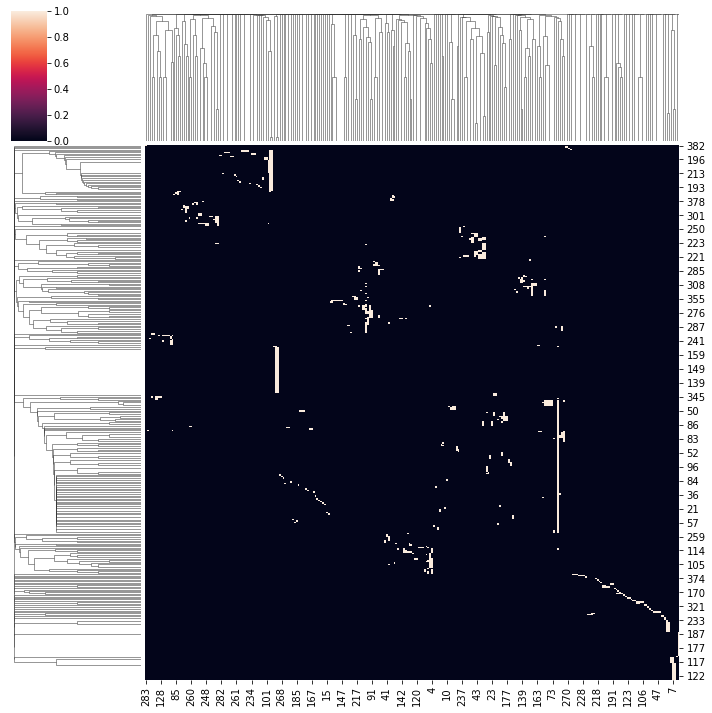

In [235]:
import seaborn as sb
g = sb.clustermap(new_Y, metric='jaccard')

In [295]:
all_sides  = []
for s in side:
    ss = s[1]
    if "," in ss or "and" in ss:
        d = [uu.strip()  for u in ss.split(",") for uu in u.split("and") if len(uu.strip())>1]
        print(d)
        all_sides += d
        
    else:
        d = ss.strip()
        if d == 'therapeutic efficacy of':
            d = 'therapeutic efficacy'
        all_sides += [d]

['bleeding', 'hemorrhage']
['bleeding', 'bruising']
['infection', 'neutropenia']
['myopathy', 'rhabdomyolysis', 'myoglobinuria']
['neutropenia', 'thrombocytopenia']
['confusion', 'irritability', 'sleep disorders']
['hyponatremia', 'water intoxication']
['hypertension', 'hyponatremia', 'water intoxication']
['orthostatic hypotension', 'syncope']
['hypotension', 'orthostatic hypotension']
['hypotension', 'sedation', 'death', 'somnolence', 'respiratory depression']
['renal failure', 'hypertension']
['nephrotoxicity', 'hypocalcemia']
['jaw osteonecrosis', 'anti-angiogenesis']
['ventricular arrhythmias', 'cardiac arrhythmia']
['serotonin syndrome', 'hypomania']
['gastrointestinal bleeding', 'peptic ulcer']
['renal failure', 'hyperkalemia', 'hypertension']
['pseudotumor cerebri', 'elevated intracranial pressure']
['rhabdomyolysis', 'myoglobinuria', 'elevated creatine kinase (cpk)']
['myopathy', 'rhabdomyolysis']
['myopathy', 'rhabdomyolysis']
['hypotension', 'hyperkalemia', 'reduced intravas

In [332]:
all_sides

['anticoagulant activities',
 'bleeding',
 'hemorrhage',
 'gastrointestinal bleeding',
 'bleeding',
 'bruising',
 'bleeding',
 'therapeutic efficacy',
 'anticoagulant activities',
 'adverse effects',
 'therapeutic efficacy',
 'hemorrhage',
 'antiplatelet activities',
 'thrombosis',
 'thrombogenic activities',
 'infection',
 'infection',
 'neutropenia',
 'immunosuppressive activities',
 'myelosuppression',
 'neutropenic activities',
 'neutropenia',
 'metabolism',
 'serum concentration drug',
 'serum concentration drug',
 'qtc-prolonging activities',
 'reduction in efficacy',
 'qtc prolongation',
 'excretion rate',
 'reduction in efficacy',
 'myopathy',
 'rhabdomyolysis',
 'myoglobinuria',
 'metabolism',
 'cardiotoxic activities',
 'cardiotoxicity',
 'myelosuppressive activities',
 'neutropenia',
 'thrombocytopenia',
 'hepatotoxic activities',
 'angioedema',
 'pulmonary toxicity',
 'peripheral neuropathy',
 'hypocalcemia',
 'cardiac arrhythmia',
 'anemia',
 'liver damage',
 'reduction in

In [299]:
#### Gigantic cluster assignment matrix to be determined.



184

In [328]:
from sklearn.manifold import MDS
mds =  MDS(n_components=2, metric=True, 
           n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, 
           random_state=None, dissimilarity='precomputed')
embeds = mds.fit_transform(distance2)

In [329]:
(np.unique([all_sides]))

array(['a hypersensitivity reaction', 'absorption', 'adverse effects',
       'alpha-adrenergic activities', 'analgesic activities', 'anemia',
       'angioedema', 'anti-angiogenesis', 'anticholinergic activities',
       'anticoagulant activities', 'anticonvulsant toxicity',
       'antihypertensive activities', 'antiplatelet activities',
       'antipsychotic activities', 'arrhythmogenic',
       'arrhythmogenic activities',
       'atrioventricular blocking (av block)',
       'atrioventricular blocking (av block) activities',
       'bioavailability', 'bleeding', 'bradycardia', 'bradycardic',
       'bradycardic activities', 'bronchoconstrictory activities',
       'bronchodilatory activities', 'bruising', 'cardiac arrest',
       'cardiac arrhythmia', 'cardiodepressant activities',
       'cardiotoxic activities', 'cardiotoxicity',
       'cardiovascular impairment',
       'central nervous system depressant (cns depressant) activities',
       'change in thyroid function activiti

In [330]:
side[1]

[1, ' bleeding and hemorrhage', 'increased  bleeding and hemorrhage']

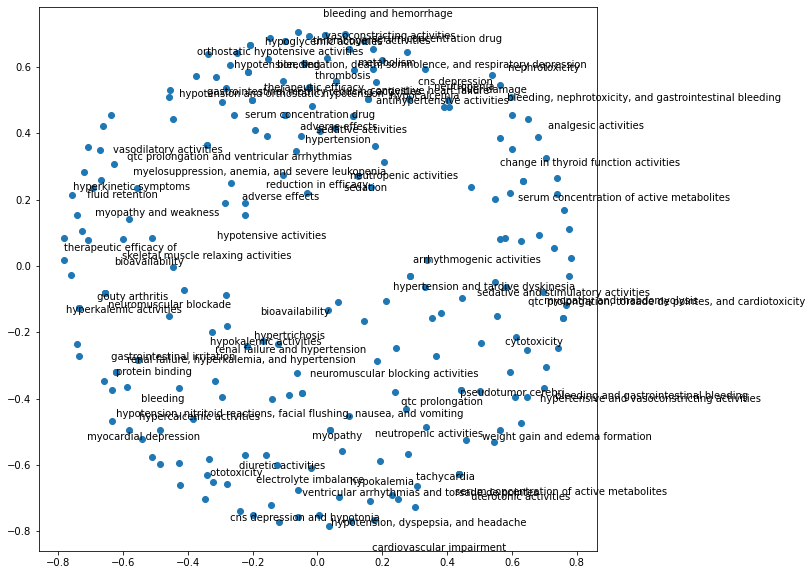

In [331]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots( figsize=(10,10))
ax.scatter(embeds[:,0], embeds[:,1])
index= np.random.choice(range(len(side)), 100)
for i in range(len(side)):
    if i in index:
        ax.annotate(side[i][1], (embeds[i,0]+ np.random.normal(0, 0.05), embeds[i,1]+ np.random.normal(0, 0.05)))

In [213]:
from sklearn.cluster import AgglomerativeClustering
ac =AgglomerativeClustering(n_clusters=None, affinity='precomputed', memory=None, 
                            connectivity=None, compute_full_tree='auto', linkage='complete', 
                            distance_threshold=0.9, compute_distances=False)
res = ac.fit_predict(distance2)

In [ ]:
res[g.dendrogram_row.reordered_ind][430:700]

In [ ]:
res[g.dendrogram_row.reordered_ind][490:700]

In [ ]:
res[g.dendrogram_row.reordered_ind][497:700]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(distance2[g.dendrogram_row.reordered_ind[500], :][g.dendrogram_row.reordered_ind])

In [ ]:
np.where(Y.iloc[85714,:]>0)[0]

In [ ]:
j = g.dendrogram_row.reordered_ind[498]
Y.iloc[j,np.where(Y.iloc[j,:]>0)[0]]

In [ ]:
dictionary['DB00191']['ddi']['DB00344']

In [ ]:
new_Y[index[g.dendrogram_row.reordered_ind],:]

In [ ]:
import seaborn as sb
sb.heatmap(distance2)

In [ ]:
from collections import defaultdict
from collections import Counter
dictionary_interactions = Counter([i for i in type_interaction if i not in stop_words and len(i)>2])


## Indication analysis

In [8]:
import pandas as pd

In [9]:
from collections import Counter

In [11]:
dictionary['DB00005']['indication']
indication = []
#### Need to create a cluster analysis
it = 0
new_it = 0
clusters_indication = []
seen_indications =[]
indications = {}
pg = []
for k in dictionary.keys():
    #print(k)
    old_int = ""
    if len(dictionary[k]['indication']) > 0:
            new_int = dictionary[k]['indication'].replace(dictionary[k]['name'], "drug")
            s = dictionary[k]['indication'].replace(dictionary[k]['name'], "drug").lower()
            s = s.replace(dictionary[k]['name'].lower(), "drug").lower()
            indications[k] = parse_indication(s)

#             if new_int not in seen_indications:
#                 seen_indications += [new_int]
#                 clusters_indication += [new_it]
#                 new_it += 1
#                 type_interaction += new_int.lower()
#             else:
#                 j = np.where([new_int == s for s in seen_indications])[0][0]
#                 clusters_indication += [j]
                
            it+=1
            if len(indications[k])==0: 
                print(k)
                pg += [k]

                
#### Usef            
#type_interaction = re.split('\W+', type_interaction.lower())   
    

NameError: name 'parse_indication' is not defined

In [751]:
pd.DataFrame.from_dict(all_int, orient= 'index').fillna(0)

anticoagulant  activities  bleeding  hemorrhage  gastrointestinal  \
0              1.0         1.0       0.0         0.0               0.0   
6              1.0         1.0       0.0         0.0               0.0   
10             0.0         1.0       0.0         0.0               0.0   
12             0.0         1.0       0.0         0.0               0.0   
15             0.0         1.0       0.0         0.0               0.0   
..             ...         ...       ...         ...               ...   
204            0.0         0.0       0.0         0.0               0.0   
208            0.0         0.0       0.0         0.0               0.0   
211            0.0         0.0       0.0         0.0               0.0   
218            0.0         0.0       0.0         0.0               0.0   
222            0.0         0.0       0.0         0.0               0.0   

     bruising  therapeutic  efficacy  adverse  effects  ...  metabolic  \
0         0.0          0.0       0.0      0.0      0.0  ...        0.0   
6         0.0          0.0       0.0      0.0      0.0  ...        0.0   
10        0.0          0.0       0.0      0.0      0.0  ...        0.0   
12        0.0          0.0       0.0      0.0      0.0  ...        0.0   
15        0.0          0.0       0.0      0.0      0.0  ...        0.0   
..        ...          ...       ...      ...      ...  ...        ...   
204       0.0          0.0       0.0      0.0      0.0  ...        0.0   
208       0.0          0.0       0.0      0.0      0.0  ...        0.0   
211       0.0          0.0       0.0      0.0      0.0  ...        0.0   
218       0.0          0.0       0.0      0.0      0.0  ...        0.0   
222       0.0          0.0       0.0      0.0      0.0  ...        0.0   

     methemoglobinemia  anticonvulsant  osteomalacia  aripiprazole  enzyme  \
0                  0.0             0.0           0.0           0.0     0.0   
6                  0.0             0.0           0.0           0.0     0.0   
10                 0.0             0.0           0.0           0.0     0.0   
12                 0.0             0.0           0.0           0.0     0.0   
15                 0.0             0.0           0.0           0.0     0.0   
..                 ...             ...           ...           ...     ...   
204                0.0             0.0           0.0           0.0     0.0   
208                0.0             0.0           0.0           0.0     0.0   
211                0.0             0.0           0.0           0.0     0.0   
218                1.0             0.0           0.0           0.0     0.0   
222                0.0             0.0           1.0           0.0     0.0   

     elevations  sinus  node  generalized  
0           0.0    0.0   0.0          0.0  
6           0.0    0.0   0.0          0.0  
10          0.0    0.0   0.0          0.0  
12          0.0    0.0   0.0          0.0  
15          0.0    0.0   0.0          0.0  
..          ...    ...   ...          ...  
204         0.0    0.0   0.0          0.0  
208         0.0    0.0   0.0          0.0  
211         0.0    0.0   0.0          0.0  
218         0.0    0.0   0.0          0.0  
222         0.0    0.0   0.0          0.0  

[234 rows x 227 columns]

In [752]:
indications

{'DB00001': ['the treatment of heparin-induced thrombocytopenia'],
 'DB00002': ['egfr-expressing, metastatic colorectal carcinoma',
  'the treatment of egfr-expressing, metastatic colorectal carcinoma',
  'combination with irinotecan, is indicated for the treatment of egfr-expressing, metastatic colorectal carcinoma in patients who are refractory to irinotecan-based chemotherapy.',
  'egfr-expressing, metastatic colorectal carcinoma',
  'the treatment of egfr-expressing, metastatic colorectal carcinoma'],
 'DB00003': ['cystic fibrosis.',
  'adjunct therapy for the treatment of cystic fibrosis.'],
 'DB00004': ['the treatment of cutaneous t-cell lymphoma'],
 'DB00005': ['moderately to severely active rheumatoid arthritis',
  'chronic moderate to severe plaque psoriasis',
  'the treatment of moderately to severely active rheumatoid arthritis',
  'chronic moderate to severe plaque psoriasis',
  'polyarticular idiopathic arthritis',
  'manage signs and symptoms of polyarticular idiopathic a

In [390]:
parse_indication(new_int.lower())


[['heparin-induced thrombocytopenia', '']]

In [564]:
s = dictionary[k]['indication']

In [569]:
dictionary[k]['indication']

'Azithromycin should be used only to treat or prevent infections that are proven or strongly suspected to be caused by susceptible bacteria in order to prevent the development antimicrobial resistance and maintain the efficacy of azithromycin [FDA label].&#13; &#13; Azithromycin is indicated for the treatment of patients with mild to moderate infections caused by susceptible strains of the microorganisms listed in the specific conditions below. Recommended dosages, duration of therapy and considerations for various patient populations may vary among these infections. Refer to the FDA label and "Indications" section of this drug entry for detailed information [FDA label]. &#13; &#13; **Adults**:&#13; &#13; Acute bacterial exacerbations of chronic obstructive pulmonary disease due to _Haemophilus influenzae_, _Moraxella catarrhalis_ or _Streptococcus pneumoniae_&#13; &#13; Acute bacterial sinusitis due to _Haemophilus influenzae_, _Moraxella catarrhalis_ or _Streptococcus pneumoniae_&#13

In [1262]:
dictionary['DB00001'].keys()

dict_keys(['drugbank_id', 'name', 'description', 'indication', 'pharmacodynamics', 'toxicity', 'metabolism', 'absorption', 'half_life', 'market_start', 'affected_organism', 'market_end', 'mechanism_of_action', 'route_of_elimination', 'volume_of_distribution', 'classification', 'carriers', 'targets', 'transporters', 'enzymes', 'go_classifiers', 'food_interactions', 'ddi', 'pathways'])

In [1264]:
dictionary['DB00002']['toxicity']

'Pulmonary Toxicity&#13; &#13; Interstitial lung disease (ILD) was reported in 3 of 633 (&lt;0.5%) patients with advanced colorectal cancer receiving cetuximab. Interstitial pneumonitis with non-cardiogenic pulmonary edema resulting in death was reported in one case. Two patients had pre-existing fibrotic lung disease and experienced an acute exacerbation of their disease while receiving cetuximab in combination with irinotecan. In the clinical investigational program, an additional case of interstitial pneumonitis was reported in a patient with head and neck cancer treated with cetuximab and cisplatin. The onset of symptoms occurred between the fourth and eleventh doses of treatment in all reported cases.'

#### Alternative parsing strategy

In [13]:
k= 'DB00002'
s = dictionary[k]['indication'].replace(dictionary[k]['name'], "drug").lower()
s = s.replace(dictionary[k]['name'].lower(), "drug").lower()

print(s)
#### Start by looking for breaks:
def parse_indication(s):
    new_s = ""
    for ss in re.split("\[l\d+]", s):
        if len(ss) > 2:
            new_s += ss
            
    s = new_s
    
    s = s.replace("twice daily treatment", "treatment")
    s = s.replace("topical treatment", "treatment")
    s = s.replace("for treatment", "for the treatment")
    s = s.replace("symptomatic treatment", "treatment")
    s = s.replace("in treatment", "for the treatment")
    s = s.replace("in the treatment of", "for the treatment of")
    s = s.replace("the symptoms", "symptoms")
    s = s.replace("use/treatment", "use")
    s = s.replace("important for", "used for")
    s = s.replace("the prevention and treatment", "the treatment")
    s = s.replace("treatment/use", "use")
    s = s.replace("use this compound as", "used as")
    s = s.replace("the signs", "signs")
    s = s.replace("people", "patients")
    s = s.replace("in those aged", "in patients aged")
    s = s.replace("and for the prevention", ". and for the treatment")
    s = s.replace("palliative treatment", "treatment")
    s = s.replace("palliative management", "management")
    s = s.replace("initial treatment", "treatment")
    s = s.replace("[", "...")
    s = s.replace("pediatric patients", "patients")
    s = s.replace("- treatment", "for the treatment")
    s = s.replace("- the treatment", "for the treatment")
    s = s.replace("- management", "for the management")
    s = s.replace("- the management", "for the management")
    s = s.replace("- reduction", "for the management")
    s = s.replace("is also", "is")
    s = s.replace("to temporarily", "to")
    s = s.replace("a minority of patients", "patients")
    s = s.replace("helps control", "helps to control")
    
    indication = [ e for e in re.findall(r'&#13;(.*?)&#13;', s) if (len(e)>2) ]
    if len(indication)==0:
        indication = [ e for e,ee in re.findall(r'&#13; &#13; (.*?)(\.|&#13)', s) if (len(e)>2) ]
    many_s = [u for u in s.replace(".", ".##############").split("##############") if len(u)>0]
    many_ss = []
    #print(many_s)
    
        
    for ss in many_s:
        #print("beg", indication)
        #print("beg", ss)
        if ss=='`code text here`':
            return("None")

        if len(re.findall("no (fda|ema)",ss))>0:
            indication += ["no approved indication"]
        if len(re.findall("there is no support",ss))>0:
            indication += ["no approved indication"]
        if len(re.findall("unsubstantiated",ss))>0:
            indication += ["no approved indication"]
        if len(re.findall("(no approved indication|no approved therapeutic indication|has no indication)",ss))>0:
            indication += ["no approved indication"]
        if len(ss)>1 and len(re.findall(r'cannot be used',ss))==0:
            #print(ss)
            ##### split if patients or adults are there
            if ss[:3]== "for" and len(re.findall(r'for (the management of)|(the treatment of)', ss))==0:
                indication += re.findall(r'for (.*?)(?=$)', ss)
            else:
                if len(re.findall(r'for the treatment of\ (.*?)\ in (adult|adults|patients)', ss))>0:
                    #print("here 1")
                    indication +=  [ e for e, ee in re.findall(r'for the treatment of\ (.*?)\ in (adult|adults|patients)', ss)]
                    #print(indication, len(indication))
                    indication += [ ee for e, ee, eee in re.findall(r'and (in|for)\ (.*?)\ in (adult|pediatric|adults|patients)', ss)]
                    #indication += [[ind, patients]]
                elif len(re.findall(r'(for|in) the treatment of\ (.*?)(?=$)', ss)):
                    indication +=  [ee for e, ee in re.findall(r'(for|in) the treatment of\ (.*?)(?=$)', ss)]
                else:
                    indication +=  [ee for e, ee in re.findall(r'treatment (of|for|to)\ (.*?)(?=$)', ss)]
                    #print(re.findall(r'(?<=for the treatment of\ )(.*?)(?=$)', ss))
                    #print(indication)
                    #indication += [[ind, patients]]
                indication +=   re.findall(r'detection of (.*?)(?=$)', s)
                indication +=   re.findall(r'for use as (.*?)(?=$)', s)
                
                if len(re.findall(r'indicated (to|for) (.*?)\ in (adult|pediatric|adults|patients)', ss))>0 and len(re.findall(r'(to treat|to prevent|in prevention of|for the treatment of) (.*?)', ss))==0:
                    #print("here 1")
                    indication +=  [ee for e, ee, eee in re.findall(r'indicated (to|for) (.*?)\ in (adult|pediatric|adults|patients)', ss)]
                    #print(indication, len(indication))
                    indication += [ e for e, ee in re.findall(r'and in\ (.*?)\ in (adult|pediatric|adults|patients)', ss)]
                elif len(re.findall(r'indicated (to|for)', ss))>0:
                    #print("here 1")
                    indication +=  [ee for e, ee in re.findall(r'indicated (to|for)\ (.*?)(?=$)', ss)]
                if len(re.findall(r'used for', ss))>0:
                    #print("here 1")
                    indication +=  re.findall(r'used for\ (.*?)(?=$)', ss)
    
                if len(re.findall(r'for the treatment of (adults |patients )with (.*?)(?=$)', ss))>0:
                    indication += [ee for e, ee in re.findall(r'for the treatment of (adults|patients) with (.*?)(?=$)', ss)]
                if len(re.findall(r'to manage (signs and symptoms of |symptoms of |signs of )', ss))>0:
                    #print("here 3")
                    #print(ss, re.findall(r'to manage (signs and symptoms of |symptoms of |signs of )(.*?)', ss))
                    indication += [ ee for e, ee in re.findall(r'to manage (signs and symptoms of |symptoms of |signs of )(.*?) in patients', ss)]
                    if len(re.findall(r'patients', ss))==0:
                        indication += [ ee for e, ee in re.findall(r'to manage (signs and symptoms of |symptoms of |signs of )(.*$)', ss)]
#                 if len(re.findall('drug is indicated for', ss))>0 and (len(re.findall(r"for the treatment of", ss)) == 0):
#                     #print("here 2")
#                     indication +=  re.findall('(?<=drug is indicated for\ )(.*?)(?=$)', ss)
                if len(re.findall(r'for the management of', ss))>0:
                    indication += re.findall(r'for the management of (.*?)(?=$)', ss)
                elif len(re.findall(r'management of', ss))>0:
                    indication += re.findall(r'management of (.*?)(?=$)', ss)
                if len(re.findall(r'to prevent', ss))>0:
                    indication += re.findall(r'to prevent (.*?)(?=$)', ss)
                if len(re.findall(r'for the prevention of', ss))>0:
                    indication += re.findall(r'for the prevention of (.*?)(?=$)', ss)
                if len(re.findall(r'to treat', ss))>0:
                    if len(re.findall(r'to treat (.*)  and to', ss)) > 0:
                        indication += re.findall(r'to treat (.*)  and to', ss)
                    else:
                        indication += re.findall(r'to treat (.*)', ss)
                if len(re.findall(r'inhibit', ss))>0:
                    if len(re.findall(r'inhibit (.*) and to', ss)) > 0:
                        indication += re.findall(r'inhibit (.*) and to', ss)
                    else:
                        indication += re.findall(r'inhibit (.*)', ss)
                indication += re.findall(r'to assist (.*).', ss)
                indication += re.findall(r'to induce (.*).', ss)
                indication += re.findall(r'to function as (.*).', ss)
                indication +=  re.findall(r'promotes(.*).', ss)
#                 if len(re.findall(r'to (relieve|reduce|assist|cause|inhibit|decrease|augment|increase) (.*),', ss))>0:
#                     indication += [ee for e, ee in re.findall(r'to (relieve|reduce|assist|cause|inhibit|decrease|augment|increase) (.*),', ss)]
                if len(re.findall(r'to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve) (.*).', ss))>0:
                    indication += [ee for e, ee in re.findall(r'to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve) (.*).', ss)]
                if len(re.findall(r'for (controlling|promoting|relieving|reducing|treating|assisting|causing|inhibiting|decreasing|augmenting|increasing) (.*).', ss))>0:
                    indication += [ee for e, ee in re.findall(r'for (controlling|promoting|relieving|reducing|treating|assisting|causing|inhibiting|decreasing|augmenting|increasing) (.*).', ss)]
                if len(re.findall(r'in (controlling|promoting|relieving|reducing|treating|assisting|causing|inhibiting|decreasing|augmenting|increasing) (.*).', ss))>0:
                    indication += [ee for e, ee in re.findall(r'in (controlling|promoting|relieving|reducing|treating|assisting|causing|inhibiting|decreasing|augmenting|increasing) (.*).', ss)]
                indication += re.findall(r'to cause (.*),', ss)
                if len(re.findall(r'used (as|to) (.*) in', ss))>0:
                    indication += [ee for e, ee in re.findall(r'used (as|to) (.*) in', ss)]
                else:
                    indication += [ee for e, ee in re.findall(r'used (as|to) (.*)', ss)]
                indication += re.findall(r'act as (.*),', ss)
                indication += [ee for e, ee in re.findall(r'(for\ use|used) in (.*?)(?=$)', ss)]
                indication +=  re.findall(r'drug is a (.*?)(?=$)', ss)
                indication +=  re.findall(r'is a (.*?) drug', ss)
                indication +=  re.findall(r'prevents (.*?) in patients', ss)
                indication +=  re.findall(r'in conditions like (.*?),', ss)
                indication +=  re.findall(r'drug of choice (.*?)(?=$)', ss)
                indication +=  re.findall(r'be of use in patients with (.*?)(?=$)',ss)
                if len(re.findall(r'(has|have) (.*?) (activity|activities)', ss))>0:
                    indication +=  [ee for e, ee, eee in re.findall(r'(has|have) (.*?) (activity|activities)', ss)]
                    


#             if len(re.findall(r'for the treatment of\ (.*?)', ss))>0 and (len(re.findall(r"adults", ss)) == 0) and (len(re.findall(r"patients", ss)) == 0):
#                 print("here4")
#                 indication += re.findall(r'(?<=for the treatment of\ ).*?(?=$)', ss)[0]
    if len(indication) == 0:
        indication = [s]
    out = []
    print(indication)
    for m in indication:
        m = m.replace("the treatment of ", "")
        m = m.replace("the management of ", "")
        m = m.replace("management of ", "")
        out+= [ u.strip() for u in re.split(',|\.|and|-', m) if len(u)>1]
        
    
              
    return(out)
parse_indication(s)

drug, used in combination with irinotecan, is indicated for the treatment of egfr-expressing, metastatic colorectal carcinoma in patients who are refractory to irinotecan-based chemotherapy. drug administered as a single agent is indicated for the treatment of egfr-expressing, metastatic colorectal carcinoma in patients who are intolerant to irinotecan-based chemotherapy.
['egfr-expressing, metastatic colorectal carcinoma', 'the treatment of egfr-expressing, metastatic colorectal carcinoma in patients who are refractory to irinotecan-based chemotherapy.', 'combination with irinotecan, is indicated for the treatment of egfr-expressing, metastatic colorectal carcinoma in patients who are refractory to irinotecan-based chemotherapy.', 'egfr-expressing, metastatic colorectal carcinoma', 'the treatment of egfr-expressing, metastatic colorectal carcinoma in patients who are intolerant to irinotecan-based chemotherapy.']


['egfr',
 'expressing',
 'metastatic colorectal carcinoma',
 'egfr',
 'expressing',
 'metastatic colorectal carcinoma in patients who are refractory to irinotecan',
 'based chemotherapy',
 'combination with irinotecan',
 'is indicated for egfr',
 'expressing',
 'metastatic colorectal carcinoma in patients who are refractory to irinotecan',
 'based chemotherapy',
 'egfr',
 'expressing',
 'metastatic colorectal carcinoma',
 'egfr',
 'expressing',
 'metastatic colorectal carcinoma in patients who are intolerant to irinotecan',
 'based chemotherapy']

In [37]:
k= 'DB14631'
s = dictionary[k]['indication'].replace(dictionary[k]['name'], "drug").lower()
s = s.replace(dictionary[k]['name'].lower(), "drug").lower()
print(s)
#### Start by looking for breaks:

def parse_indication2(s):
    s = re.sub("f\d+", '', s)
    s = re.sub("a\d+", '', s)
    s = re.sub("l\d+", '', s)
    s = re.sub("t\d+", '', s)
    s = re.sub("\d+", '', s)
    
    s = re.sub("\[fda label\]", '', s)
    s = re.sub("\]", '', s)
    s = re.sub("\[", '', s)
    s = s.replace('as adjunctive therapy', '')
    #s = re.sub(",", '', s)
    s = s.replace("fro the treatment", "for the treatment")
    s = s.replace("inflamatory", "inflammatory")
    s = s.replace("however", ".")
    s = s.replace("as well as", "and")
    s = s.replace("including treat", "and to treat")
    s = s.replace("individuals", "patients")
    s = s.replace("as well used", "used")
    s = s.replace("twice daily treatment", "treatment")
    s = s.replace("topical treatment", "treatment")
    s = s.replace("acute treatment", "treatment")
    s = s.replace("for treatment", "for the treatment")
    s = s.replace("symptomatic treatment", "treatment")
    s = s.replace("in treatment", "for the treatment")
    s = s.replace("in the treatment of", "for the treatment of")
    s = s.replace("the symptoms", "symptoms")
    s = s.replace("use/treatment", "for the treatment")
    s = s.replace("important for", "used for")
    s = s.replace("the prevention and treatment", "the treatment")
    s = s.replace("treatment/use", "use")
    s = s.replace("use this compound as", "used as")
    s = s.replace("the signs", "signs")
    s = s.replace("people", "patients")
    s = s.replace("in conjunction", "along with")
    s = s.replace("in those aged", "in patients aged")
    s = s.replace("and for the prevention", ". and for the treatment")
    s = s.replace("palliative treatment", "treatment")
    s = s.replace("palliative management", "management")
    s = s.replace("initial treatment", "treatment")
    s = re.sub('[0-9]* years of age and older', '', s)
    s = s.replace("pediatric patients", "patients")
    s = s.replace("adult patients", "patients")
    s = s.replace("- treatment", "for the treatment")
    s = s.replace("- the treatment", "for the treatment")
    s = s.replace("- management", "for the management")
    s = s.replace("- the management", "for the management")
    s = s.replace("- reduction", "for the management")
    s = s.replace("is also", "is")
    s = s.replace(" speed ", " ")
    s = s.replace("and to", ".to")
    s = s.replace("to temporarily", "to")
    s = s.replace("to manage symptoms of", "for the treatment of")
    s = s.replace("a minority of patients", "patients")
    s = s.replace("helps control", "helps to control")
    #s = s.replace("is indicated for", "is indicated for the treatment of")
    s = s.replace("for management", "for the management")

    indication  = []
    many_s  = []
    #indication = [ e for e in re.findall(r'&#13;(.*?)&#13;', s) if (len(e)>2) and len(re.findall("drug is indicated as",e))==0  and len(e.split(" "))<5 ]
    #if len(indication)==0:
    #    indication = [ e for e, ee in re.findall(r'&#13; &#13; (.*?)(\.|&#13)', s) if (len(e)>2) ]
    if len(re.findall("&#13; &#13;", s))>0:
        if len(re.findall(r'&#13; &#13; (.*?)&#13; &#13;', s))>0:
            many_s += [ ee  for e in re.findall(r'(.*?)&#13; &#13;', s) for ee in re.split('\.|;', e) if len(ee)>0]
            for e in re.findall(r'&#13; &#13; (.*?)&#13; &#13;', s):
                if len(re.findall(" is ", e))>0:
                    many_s += re.split('\.|;', e)
                else:
                    indication +=[e]
            many_s += [ ee  for e in re.findall(r'&#13; &#13;(.*?)', s) for ee in re.split('\.|;', u)if len(ee)>0]
        else:
            many_s = [uu for u in s.split("&#13; &#13;") for uu in re.split('\.|;', u)  if len(uu)>0]
    else:
        #print("h here")
        many_s += [u for u in re.split('\.|;', s) if len(u)>0] 
    
    #print("may s", many_s)
    
        
    for ss in many_s:
        #print("beg", indication)
        #print("beg", ss)
        if ss=='`code text here`':
            return("None")

        if len(re.findall("no (fda|ema)",ss))>0:
            indication += ["no approved indication"]
        if len(re.findall("there is no support",ss))>0:
            indication += ["no approved indication"]
        if len(re.findall("unsubstantiated",ss))>0:
            indication += ["no approved indication"]
        if len(re.findall("(no approved indication|no approved therapeutic indication|has no indication)",ss))>0:
            indication += ["no approved indication"]
        if len(ss)>1 and len(re.findall(r'cannot be used',ss))==0:
            #print(ss)
            ##### split if patients or adults are there
            if ss[:3]== "for" and len(re.findall(r'for (the management of)|(the treatment of)', ss))==0:
                indication += re.findall(r'for (.*?)(?=$)', ss)
            else:
                
                if len(re.findall(r'in (patients|adults|pediatric patients|children|teenagers|women|pregnant women)', ss)):
                    if len(re.findall(r'for the (management|treatment) of (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women)', ss))>0:
                         indication += [e for _,e, ee in re.findall(r'for the (management|treatment) of (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women)', ss)]
                    elif len(re.findall(r'of (patients|adults|pediatric patients|children|teenagers|women|pregnant women)', ss)):
                        indication += [ee for e, ee in re.findall(r'for the treatment of (patients|adults|pediatric patients|children|teenagers|women|pregnant women) (.*?)(?=$)', ss)]
                    elif len(re.findall(r'for (patients|adults|pediatric patients|children|teenagers|women|pregnant women) with', ss)):
                        #print("yes", ss, re.findall(r'for (patients|adults|pediatric patients|children|teenagers|women|pregnant women) with (.*?)(?=$)', ss))
                        indication += [ee for e, ee in re.findall(r'for (patients|adults|pediatric patients|children|teenagers|women|pregnant women) with (.*?)(?=$)', ss)]
                    elif len(re.findall("indicated to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|treat) (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women) with (.*) receiving", ss))>0:
                        #print("usted")
                        #print(re.findall("indicated to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve) (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women) with (.*) receiving", ss))
                        indication += [ee + " "+ eeee for e, ee, eee, eeee in re.findall("indicated to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|treat) (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women) with (.*) receiving", ss)]
                    elif len(re.findall("indicated to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|treat) (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women) with (.*)", ss))>0:
                        indication += [ee + " "+ eeee for e, ee, eee, eeee in re.findall("indicated to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|treat) (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women) with (.*?)(?=$)", ss)]
                    elif len(re.findall("indicated to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|treat) (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women) (.*)", ss))>0:
                        indication += [ee + " "+ eeee for e, ee, eee, eeee in re.findall("indicated to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|treat) (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women) (.*?)(?=$)", ss)]
                    elif len(re.findall(r'(patients|adults|pediatric patients|children|teenagers|women|pregnant women) with', ss)):
                        indication += [ee  for e, ee  in re.findall(r'(patients|adults|pediatric patients|children|teenagers|women|pregnant women) with (.*?)(?=$)', ss)]
                    elif len(re.findall("indicated for the relief of symptoms (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women)", ss))>0:
                        indication += [e for e, _ in re.findall("indicated for the relief of symptoms (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women)", ss)]
                    elif len(re.findall(r'to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|prevent|treat) (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women)', ss))>0:
                        indication += [ee for e, ee, _ in re.findall(r'to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|prevent|treat) (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women)', ss)]
                    elif  len(re.findall(r'is (approved|indicated|fda-approved) (.*) for (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women)', ss))>0:
                        indication += [e for _,_,e, ee in re.findall(r'is (approved|indicated|fda-approved) (.*) for (.*) in (patients|adults|pediatric patients|children|teenagers|women|pregnant women)', ss)]
                    elif len(re.findall(r'in (patients|adults|pediatric patients|children|teenagers|women|pregnant women) (.*) used to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|prevent|treat) (.*?)(?=$)', ss))>0:
                        indication += [e for _, _, _, e in re.findall(r'in (patients|adults|pediatric patients|children|teenagers|women|pregnant women) (.*) used to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|prevent|treat) (.*?)(?=$)', ss)]
                    else:
                        print("here")
                else:
                    #print("no")
                    if len(re.findall(r'is (approved|indicated|fda-approved) for', ss))>0:
                        indication += [ee for e, ee in re.findall(r'is (approved|indicated|fda-approved) for (.*?)(?=$)', ss)]
                    elif len(re.findall("indicated to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve)", ss))>0:
                        indication += [ee for e, ee in re.findall("indicated to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve) (.*?)(?=$)", ss)]
                    elif len(re.findall("(approved|indicated) for", ss))>0:
                        indication += [ee for e, ee in re.findall(r'(approved|indicated|fda-approved) for (.*?)(?=$)', ss)]
                    if len(re.findall(r'(for|in) the (treatment|management|prevention) of', ss))>0:
                        indication += [ee for _, e, ee in re.findall(r'(for|in) the (treatment|management|prevention) of (.*?)(?=$)', ss)]
                    elif len(re.findall(r'(for|in|) the (treatment|management|prevention) in', ss))>0:
                        indication += [ee for _, e, ee in re.findall(r'(for|in) the (treatment|management|prevention) in (.*?)(?=$)', ss)]
                    
                    elif len(re.findall(r'to treat', ss))>0:
                        if len(re.findall(r'to treat (.*)  and to', ss)) > 0:
                            indication += re.findall(r'to treat (.*)  and to', ss)
                        else:
                            indication += re.findall(r'to treat (.*)', ss)
                    else:
                        indication += re.findall(r'to assist (.*)', ss)
                        indication += re.findall(r'to induce (.*)', ss)
                        indication += re.findall(r'to function as (.*)', ss)
                        indication +=  re.findall(r'promotes(.*)', ss)
                        if len(re.findall(r'to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|prevent) (.*) in', ss))>0:
                            indication += [ee for e, ee in re.findall(r'to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|prevent) (.*) in', ss)]
                        elif len(re.findall(r'to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|prevent) (.*)', ss))>0:
                            indication += [ee for e, ee in re.findall(r'to (produce|elicit|control|promote|relieve|reduce|assist|cause|inhibit|decrease|augment|increase|improve|prevent) (.*)', ss)]
                        if len(re.findall(r'for (controlling|promoting|relieving|reducing|treating|assisting|causing|inhibiting|decreasing|augmenting|increasing) (.*)', ss))>0:
                            indication += [ee for e, ee in re.findall(r'for (controlling|promoting|relieving|reducing|treating|assisting|causing|inhibiting|decreasing|augmenting|increasing) (.*)', ss)]
                        if len(re.findall(r'in (controlling|promoting|relieving|reducing|treating|assisting|causing|inhibiting|decreasing|augmenting|increasing) (.*)', ss))>0:
                            indication += [ee for e, ee in re.findall(r'in (controlling|promoting|relieving|reducing|treating|assisting|causing|inhibiting|decreasing|augmenting|increasing) (.*)', ss)]
                        indication += re.findall(r'to cause (.*),', ss)
                        indication += [ee for e, ee in re.findall(r'used (as|to|for) (.*?)(?=$)', ss)]
                        indication += re.findall(r'to act as(.*)', ss)
                        #print(re.findall(r'to act as(.*)', ss), ss)
                        indication += [ee for e, ee in re.findall(r'(for\ use|used) in (.*?)(?=$)', ss)]
                        indication +=  re.findall(r'drug is a (.*?)(?=$)', ss)
                        indication +=  re.findall(r'is a (.*?) drug', ss)
                        indication +=  re.findall(r'has ((?:(?!has).)*?) properties', ss)
                        indication +=  re.findall(r'prevents (.*?) in patients', ss)
                        indication +=  re.findall(r'protect against (.*?)(?=$),', ss)
                        indication +=  re.findall(r'helpful in (.*?)(?=$)', ss)
                        indication +=  re.findall(r'healing of (.*?)(?=$)', ss)
                        indication +=  [ee for _,ee in re.findall(r'(aids|helps) (.*?)(?=$)', ss)]
                        indication +=  re.findall(r'in conditions like (.*?)', ss)
                        indication +=  re.findall(r'drug of choice (.*?)(?=$)', ss)
                        indication +=  re.findall(r'be of use in patients with (.*?)(?=$)',ss)
                        indication += re.findall(r'is being studied for its activity against (.*?)(?=$)', ss)
                        if len(re.findall(r'(has|have) (.*?) (activity|activities)', ss))>0:
                            indication +=  [ee for e, ee, eee in re.findall(r'(has|have) (.*?) (activity|activities)', ss)]


                #print(indication)
#             if len(re.findall(r'for the treatment of\ (.*?)', ss))>0 and (len(re.findall(r"adults", ss)) == 0) and (len(re.findall(r"patients", ss)) == 0):
#                 print("here4")
#                 indication += re.findall(r'(?<=for the treatment of\ ).*?(?=$)', ss)[0]
#     if len(indication) == 0:
#         indication = [s]
    out = []
#     print("many_s")
#     print(many_s)
    #print(indication)
    for m in indication:
        m = m.replace("the treatment of ", "")
        m = m.replace("the management of ", "")
        m = m.replace("management of ", "")
        m = m.replace("symptoms of ", "")
        m = m.replace("in combination with other antiviral drugs", "")
        m = m.replace("who have ", "")
        m = m.replace("#", "")
        m = m.replace("&", "")
        m = m.replace("*", "")
        out+= [ u.strip() for u in re.split('\.', m) if len(u)>1]
        
              
    return(out)
parse_indication2(s)

drug is indication to a number of conditions including treat allergic states, dermatologic diseases, edematous states, endocrine disorders, gastrointestinal diseases, hematologic disorders, neoplastic diseases, nervous system, ophthalmic diseases, respiratory diseases, rheumatic disorders.[l9437,l9440]


['allergic states, dermatologic diseases, edematous states, endocrine disorders, gastrointestinal diseases, hematologic disorders, neoplastic diseases, nervous system, ophthalmic diseases, respiratory diseases, rheumatic disorders']

In [38]:
indication = []
#### Need to create a cluster analysis
it = 0
new_it = 0
clusters_indication = []
seen_indications =[]
indications = {}
pg = []
for k in dictionary.keys():
    #print(k)
    old_int = ""
    if len(dictionary[k]['indication']) > 0:
            new_int = dictionary[k]['indication'].replace(dictionary[k]['name'], "drug")
            s = dictionary[k]['indication'].replace(dictionary[k]['name'], "drug").lower()
            s = s.replace(dictionary[k]['name'].lower(), "drug").lower()
            indications[k] = parse_indication2(s)

#             if new_int not in seen_indications:
#                 seen_indications += [new_int]
#                 clusters_indication += [new_it]
#                 new_it += 1
#                 type_interaction += new_int.lower()
#             else:
#                 j = np.where([new_int == s for s in seen_indications])[0][0]
#                 clusters_indication += [j]
                
            it+=1
            if len(indications[k])==0: 
                print(k)
                pg += [k]

                
#### Usef            
#type_interaction = re.split('\W+', type_interaction.lower())   
indications   
    

here
here
here
here
DB00043
DB00051
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
DB00208
here
here
here
here
here
here
here
DB00271
here
DB00294
here
here
here
here
here
here
here
here
here
here
here
here
DB00335
here
here
here
here
here
DB00347
here
here
here
here
here
here
DB00423
here
DB00425
DB00437
here
here
here
DB00461
here
here
here
here
here
here
DB00476
DB00522
here
here
here
here
DB00617
DB00635
here
here
here
here
here
DB00688
here
here
here
here
here
DB00743
here
here
here
here
here
DB00841
here
here
here
here
here
here
here
here
here
here
here
DB00934
here
here
DB00957
DB00977
here
here
DB01047
here
here
here
here
here
here
DB01118
DB01123
here
here
here
DB01173
here
here
DB01207
here
here
here
here
here
DB01256
here
here
here
DB01354
DB01373
DB01392
here
here
here
DB01422
DB01454
DB01497
DB01546
DB01564
here
here
DB01586
here
DB01593
DB01604
DB01645
here
here
DB02659
DB03783
DB03843
DB04335
DB04844
DB04872
DB049

{'DB00001': ['heparin-induced thrombocytopenia'],
 'DB00002': ['egfr-expressing, metastatic colorectal carcinoma',
  'egfr-expressing, metastatic colorectal carcinoma'],
 'DB00003': ['cystic fibrosis'],
 'DB00004': ['cutaneous t-cell lymphoma'],
 'DB00005': ['moderately to severely active rheumatoid arthritis in adults and in chronic moderate to severe plaque psoriasis',
  'psoriatic arthritis and ankylosing spondylitis'],
 'DB00006': ['heparin-induced thrombocytopenia', 'thrombosis'],
 'DB00007': ['advanced prostate cancer,  and for patients with central precocious puberty (cpp)',
  'advanced prostate cancer,  and for patients with central precocious puberty (cpp)',
  'endometriosis',
  'endometriosis',
  'the preoperative hematological improvement of anemic patients with uterine leiomyomata (uterine fibroids)'],
 'DB00008': ['hcv',
  'contraindications to or significant intolerance to other anti-viral therapies'],
 'DB00009': ['acute myocardial infarction, acute ischemic strok and fo

In [102]:
indications


{'DB00001': ['heparin-induced thrombocytopenia'],
 'DB00002': ['egfr-expressing, metastatic colorectal carcinoma',
  'egfr-expressing, metastatic colorectal carcinoma'],
 'DB00003': ['cystic fibrosis'],
 'DB00004': ['cutaneous t-cell lymphoma'],
 'DB00005': ['moderately to severely active rheumatoid arthritis in adults and in chronic moderate to severe plaque psoriasis',
  'psoriatic arthritis and ankylosing spondylitis'],
 'DB00006': ['heparin-induced thrombocytopenia', 'thrombosis'],
 'DB00007': ['advanced prostate cancer,  and for patients with central precocious puberty (cpp)',
  'advanced prostate cancer,  and for patients with central precocious puberty (cpp)',
  'endometriosis',
  'endometriosis',
  'the preoperative hematological improvement of anemic patients with uterine leiomyomata (uterine fibroids)'],
 'DB00008': ['hcv',
  'contraindications to or significant intolerance to other anti-viral therapies'],
 'DB00009': ['acute myocardial infarction, acute ischemic strok and fo

245

In [42]:
pg

['DB00043',
 'DB00051',
 'DB00208',
 'DB00271',
 'DB00294',
 'DB00335',
 'DB00347',
 'DB00423',
 'DB00425',
 'DB00437',
 'DB00461',
 'DB00476',
 'DB00522',
 'DB00617',
 'DB00635',
 'DB00688',
 'DB00743',
 'DB00841',
 'DB00934',
 'DB00957',
 'DB00977',
 'DB01047',
 'DB01118',
 'DB01123',
 'DB01173',
 'DB01207',
 'DB01256',
 'DB01354',
 'DB01373',
 'DB01392',
 'DB01422',
 'DB01454',
 'DB01497',
 'DB01546',
 'DB01564',
 'DB01586',
 'DB01593',
 'DB01604',
 'DB01645',
 'DB02659',
 'DB03783',
 'DB03843',
 'DB04335',
 'DB04844',
 'DB04872',
 'DB04900',
 'DB04919',
 'DB04946',
 'DB04953',
 'DB05198',
 'DB05199',
 'DB05200',
 'DB05201',
 'DB05202',
 'DB05204',
 'DB05205',
 'DB05207',
 'DB05249',
 'DB05252',
 'DB05255',
 'DB05263',
 'DB05264',
 'DB05268',
 'DB05282',
 'DB05285',
 'DB05292',
 'DB05332',
 'DB05381',
 'DB05541',
 'DB06168',
 'DB06206',
 'DB06207',
 'DB06210',
 'DB06212',
 'DB06213',
 'DB06237',
 'DB06404',
 'DB06589',
 'DB06605',
 'DB06616',
 'DB06654',
 'DB06693',
 'DB06698',
 'DB

In [47]:
it = 0

indication_str = ""
for k in dictionary.keys():
    #print(k)
    s = dictionary[k]['indication'].replace(dictionary[k]['name'], "").lower()
    s = s.replace(dictionary[k]['name'].lower(), "").lower()
    indication_str += s

In [48]:
it = 0

indication_str = ""
for k in dictionary.keys():
    #print(k)
    s = dictionary[k]['indication'].replace(dictionary[k]['name'], "").lower()
    s = s.replace(dictionary[k]['name'].lower(), "").lower()
    indication_str += s
    
indication_str = indication_str.replace("&#13;", "")
indication_str = re.sub("l\d+", "", indication_str )
indication_str = re.sub("L\d+", "", indication_str )
indication_str = re.sub("_", "", indication_str )
indication_str = re.sub("\*", "", indication_str )
indication_str = re.sub("A\d+", "", indication_str )
indication_str = re.sub("F\d+", "", indication_str )
indication_str = re.sub("G\d+", "", indication_str )
indication_str = re.sub("T\d+", "", indication_str )
indication_str = indication_str.replace("&lt;/i&gt", "")
indication_str = indication_str.replace("&lt;i&gt", "")
indication_str = indication_str.replace("&lt;b&", "")

In [49]:
indication_str = re.sub(r'[^\w\s]', ' ', indication_str).lower()
all_indic_words =Counter(indication_str.split(" "))

In [51]:
len(all_indic_words)

9483

In [52]:
all_indic_words.most_common(50)

[('', 24127),
 ('of', 5722),
 ('the', 4873),
 ('for', 4869),
 ('and', 4823),
 ('in', 4648),
 ('treatment', 3374),
 ('is', 2564),
 ('to', 2408),
 ('with', 2096),
 ('or', 1729),
 ('as', 1623),
 ('indicated', 1577),
 ('use', 1569),
 ('a', 1347),
 ('used', 1294),
 ('patients', 1252),
 ('investigated', 1021),
 ('cancer', 767),
 ('disease', 732),
 ('an', 713),
 ('also', 669),
 ('by', 599),
 ('it', 596),
 ('be', 570),
 ('label', 506),
 ('infections', 476),
 ('fda', 473),
 ('are', 444),
 ('therapy', 443),
 ('combination', 415),
 ('acute', 407),
 ('s', 389),
 ('disorders', 379),
 ('who', 375),
 ('chronic', 372),
 ('other', 367),
 ('adults', 336),
 ('not', 331),
 ('treat', 330),
 ('that', 321),
 ('management', 309),
 ('caused', 290),
 ('have', 289),
 ('may', 278),
 ('associated', 276),
 ('pain', 266),
 ('severe', 263),
 ('this', 263),
 ('has', 262)]

In [53]:
no_go_words = [e for e, ee in all_indic_words.most_common(60) if e not in ["infections", "cancer", "fda",  'adults', 'disease', 'infection', 'investigated', 'therapy', 'chronic', 
                                                              'disorders', 'pain', 'severe', 'symptoms', 'tumors', 'skin']] + ['when', '1','can', 'which', 'at', 'on','such','its', 'was']

In [54]:
indication_str = indication_str.replace("vitamin e", "vitaminE")
indication_str = indication_str.replace("vitamin a", "vitaminA")
indication_str = indication_str.replace("vitamin c", "vitaminC")
indication_str = indication_str.replace("vitamin d", "vitaminD")

In [55]:
for w in no_go_words:
    indication_str = indication_str.replace(" "+ w + " ", " ")

In [56]:
indication_str

'for heparin induced thrombocytopenia irinotecan egfr expressing metastatic colorectal carcinoma refractory irinotecan based chemotherapy  administered single agent egfr expressing metastatic colorectal carcinoma intolerant irinotecan based chemotherapy adjunct therapy cystic fibrosis cutaneous t cell lymphoma moderately severely active rheumatoid arthritis adults chronic moderate severe plaque psoriasis 4 age older  manage signs symptoms polyarticular idiopathic arthritis those aged older  manage symptoms psoriatic arthritis ankylosing spondylitis heparin induced thrombocytopenia prevention thrombosis  undergoing percutaneous coronary intervention pci  moderate high risk coronary syndromes unstable angina non st segment elevation whom pci planned palliative advanced prostate cancer   well pediatric central precocious puberty cpp    oral norethisterone  known norethindrone  initial symptoms endometriosis  finally iron supplementation  preoperative hematological improvement anemic uteri

In [57]:
all_indic_words = Counter([u for u in indication_str.split(" ") if u!=""])

In [60]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/cdonnat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
#lemmatizer.lemmatize("drugs")
word_list = nltk.word_tokenize(indication_str)

# Lemmatize list of words and join
lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
print(lemmatized_output)

for heparin induced thrombocytopenia irinotecan egfr expressing metastatic colorectal carcinoma refractory irinotecan based chemotherapy administered single agent egfr expressing metastatic colorectal carcinoma intolerant irinotecan based chemotherapy adjunct therapy cystic fibrosis cutaneous t cell lymphoma moderately severely active rheumatoid arthritis adult chronic moderate severe plaque psoriasis 4 age older manage sign symptom polyarticular idiopathic arthritis those aged older manage symptom psoriatic arthritis ankylosing spondylitis heparin induced thrombocytopenia prevention thrombosis undergoing percutaneous coronary intervention pci moderate high risk coronary syndrome unstable angina non st segment elevation whom pci planned palliative advanced prostate cancer well pediatric central precocious puberty cpp oral norethisterone known norethindrone initial symptom endometriosis finally iron supplementation preoperative hematological improvement anemic uterine leiomyomata uterin

In [62]:
all_indic_words = Counter(nltk.word_tokenize(lemmatized_output))
all_indic_words.most_common(2000)

[('investigated', 1022),
 ('disease', 839),
 ('cancer', 776),
 ('infection', 699),
 ('disorder', 546),
 ('therapy', 482),
 ('fda', 473),
 ('chronic', 372),
 ('adult', 336),
 ('agent', 297),
 ('tumor', 277),
 ('drug', 272),
 ('pain', 272),
 ('severe', 263),
 ('symptom', 241),
 ('condition', 239),
 ('cell', 236),
 ('type', 230),
 ('syndrome', 226),
 ('skin', 221),
 ('prevention', 215),
 ('approved', 215),
 ('non', 206),
 ('hypertension', 199),
 ('age', 196),
 ('indication', 192),
 ('older', 187),
 ('risk', 185),
 ('unspecified', 184),
 ('relief', 183),
 ('product', 177),
 ('moderate', 176),
 ('blood', 176),
 ('deficiency', 171),
 ('metastatic', 165),
 ('arthritis', 162),
 ('following', 159),
 ('heart', 153),
 ('surgery', 150),
 ('tract', 150),
 ('allergic', 148),
 ('adjunct', 146),
 ('leukemia', 146),
 ('diabetes', 146),
 ('pediatric', 145),
 ('susceptible', 144),
 ('well', 142),
 ('oral', 142),
 ('breast', 142),
 ('failure', 142),
 ('lung', 142),
 ('inflammatory', 139),
 ('symptomatic',

In [63]:
len(all_indic_words)

8829

In [77]:
all_indic_words.most_common(100)

[('investigated', 1022),
 ('disease', 839),
 ('cancer', 776),
 ('infection', 699),
 ('disorder', 546),
 ('therapy', 482),
 ('fda', 473),
 ('chronic', 372),
 ('adult', 336),
 ('agent', 297),
 ('tumor', 277),
 ('drug', 272),
 ('pain', 272),
 ('severe', 263),
 ('symptom', 241),
 ('condition', 239),
 ('cell', 236),
 ('type', 230),
 ('syndrome', 226),
 ('skin', 221),
 ('prevention', 215),
 ('approved', 215),
 ('non', 206),
 ('hypertension', 199),
 ('age', 196),
 ('indication', 192),
 ('older', 187),
 ('risk', 185),
 ('unspecified', 184),
 ('relief', 183),
 ('product', 177),
 ('moderate', 176),
 ('blood', 176),
 ('deficiency', 171),
 ('metastatic', 165),
 ('arthritis', 162),
 ('following', 159),
 ('heart', 153),
 ('surgery', 150),
 ('tract', 150),
 ('allergic', 148),
 ('adjunct', 146),
 ('leukemia', 146),
 ('diabetes', 146),
 ('pediatric', 145),
 ('susceptible', 144),
 ('well', 142),
 ('oral', 142),
 ('breast', 142),
 ('failure', 142),
 ('lung', 142),
 ('inflammatory', 139),
 ('symptomatic',

In [71]:
all_indic_words.most_common()[-4000:]

[('truxima', 1),
 ('digitoxin', 1),
 ('lymphomafor', 1),
 ('strabismus', 1),
 ('cosmetically', 1),
 ('frown', 1),
 ('eyebrow', 1),
 ('glabellar', 1),
 ('sweating', 1),
 ('amylase', 1),
 ('a32721', 1),
 ('a32736', 1),
 ('deterioration', 1),
 ('parenchyma', 1),
 ('a32723', 1),
 ('evolving', 1),
 ('transmural', 1),
 ('emolism', 1),
 ('cannulae', 1),
 ('campath', 1),
 ('azathioprine', 1),
 ('secondly', 1),
 ('membranous', 1),
 ('blistering', 1),
 ('a139', 1),
 ('a174085', 1),
 ('a189393', 1),
 ('a189396', 1),
 ('a189399', 1),
 ('psoriasisfor', 1),
 ('adrenaline', 1),
 ('localising', 1),
 ('ischaemia', 1),
 ('rejectionthis', 1),
 ('leucocyte', 1),
 ('neutrophil', 1),
 ('bmt', 1),
 ('leukapheresis', 1),
 ('neupogen', 1),
 ('myelosuppression', 1),
 ('flushing', 1),
 ('vasoactive', 1),
 ('vipoma', 1),
 ('lanreotide', 1),
 ('abbreviation', 1),
 ('casued', 1),
 ('zenapax', 1),
 ('rejectionas', 1),
 ('endothelial', 1),
 ('interestingly', 1),
 ('ali', 1),
 ('tumorsfor', 1),
 ('calomist', 1),
 ('f3

In [72]:
all_indic_words['for']

4

In [80]:
%pip install gensim

     |████████████████████████████████| 24.0 MB 7.6 MB/s eta 0:00:011
  Using cached smart_open-6.0.0-py3-none-any.whl (58 kB)
Note: you may need to restart the kernel to use updated packages.


In [90]:
import gensim
from gensim.utils import simple_preprocess
import nltk

In [82]:
import gensim
from gensim.utils import simple_preprocess
import nltk
indications_list = []
for k in dictionary.keys():
    print(k)
    indication_str = dictionary[k]['indication'] #### same preprocessing
    indication_str = indication_str.replace("&#13;", "")
    indication_str = re.sub("l\d+", "", indication_str )
    indication_str = re.sub("L\d+", "", indication_str )
    indication_str = re.sub("_", "", indication_str )
    indication_str = re.sub("A\d+", "", indication_str )
    indication_str = re.sub("F\d+", "", indication_str )
    indication_str = re.sub("G\d+", "", indication_str )
    indication_str = re.sub("T\d+", "", indication_str )
    indication_str = indication_str.replace("&lt;/i&gt", "")
    indication_str = indication_str.replace("&lt;i&gt", "")
    indication_str = indication_str.replace("&lt;b&", "")
    indication_str = indication_str.replace("vitamin e", "vitaminE")
    indication_str = indication_str.replace("vitamin a", "vitaminA")
    indication_str = indication_str.replace("vitamin c", "vitaminC")
    indication_str = indication_str.replace("vitamin d", "vitaminD")
    indication_str = indication_str.replace("t cells", "tCell")
    indication_str = re.sub(r'[^\w\s]', ' ', indication_str).lower()
    for w in no_go_words:
        indication_str = indication_str.replace(" "+ w + " ", " ")
    new_word_list = nltk.word_tokenize(indication_str)
    indications_list += [[lemmatizer.lemmatize(w) for w in new_word_list if all_indic_words[w]>1 ]]
    

DB00001
DB00002
DB00003
DB00004
DB00005
DB00006
DB00007
DB00008
DB00009
DB00010
DB00011
DB00012
DB00013
DB00014
DB00015
DB00016
DB00017
DB00018
DB00019
DB00020
DB00022
DB00023
DB00024
DB00025
DB00026
DB00027
DB00028
DB00029
DB00030
DB00031
DB00032
DB00033
DB00034
DB00035
DB00036
DB00038
DB00039
DB00040
DB00041
DB00042
DB00043
DB00044
DB00045
DB00046
DB00047
DB00048
DB00049
DB00050
DB00051
DB00052
DB00053
DB00054
DB00055
DB00056
DB00057
DB00058
DB00059
DB00060
DB00061
DB00062
DB00063
DB00065
DB00066
DB00067
DB00068
DB00069
DB00070
DB00071
DB00072
DB00073
DB00074
DB00075
DB00076
DB00078
DB00080
DB00081
DB00082
DB00083
DB00085
DB00086
DB00087
DB00088
DB00089
DB00090
DB00091
DB00092
DB00093
DB00094
DB00095
DB00097
DB00098
DB00099
DB00100
DB00102
DB00103
DB00104
DB00105
DB00106
DB00107
DB00108
DB00109
DB00110
DB00111
DB00112
DB00113
DB00114
DB00115
DB00116
DB00117
DB00118
DB00119
DB00120
DB00121
DB00122
DB00123
DB00125
DB00126
DB00127
DB00128
DB00129
DB00130
DB00131
DB00132
DB00133
DB00134


DB01103
DB01104
DB01105
DB01106
DB01107
DB01108
DB01109
DB01110
DB01111
DB01112
DB01113
DB01114
DB01115
DB01116
DB01117
DB01118
DB01119
DB01120
DB01121
DB01122
DB01123
DB01124
DB01125
DB01126
DB01127
DB01128
DB01129
DB01130
DB01131
DB01132
DB01133
DB01134
DB01135
DB01136
DB01137
DB01138
DB01139
DB01140
DB01141
DB01142
DB01143
DB01144
DB01145
DB01146
DB01147
DB01148
DB01149
DB01150
DB01151
DB01152
DB01153
DB01154
DB01155
DB01156
DB01157
DB01158
DB01159
DB01160
DB01161
DB01162
DB01163
DB01164
DB01165
DB01166
DB01167
DB01168
DB01169
DB01170
DB01171
DB01172
DB01173
DB01174
DB01175
DB01176
DB01177
DB01178
DB01179
DB01180
DB01181
DB01182
DB01183
DB01184
DB01185
DB01186
DB01187
DB01188
DB01189
DB01190
DB01191
DB01192
DB01193
DB01194
DB01195
DB01196
DB01197
DB01198
DB01199
DB01200
DB01201
DB01202
DB01203
DB01204
DB01205
DB01206
DB01207
DB01208
DB01209
DB01210
DB01211
DB01212
DB01213
DB01214
DB01215
DB01216
DB01217
DB01218
DB01219
DB01220
DB01221
DB01222
DB01223
DB01224
DB01225
DB01226
DB01227


DB02952
DB02953
DB02954
DB02955
DB02956
DB02957
DB02958
DB02959
DB02960
DB02961
DB02962
DB02963
DB02964
DB02965
DB02966
DB02967
DB02968
DB02969
DB02970
DB02971
DB02972
DB02973
DB02974
DB02975
DB02976
DB02977
DB02978
DB02979
DB02980
DB02981
DB02982
DB02983
DB02984
DB02985
DB02986
DB02987
DB02988
DB02989
DB02990
DB02991
DB02992
DB02993
DB02994
DB02995
DB02996
DB02998
DB02999
DB03000
DB03001
DB03002
DB03003
DB03004
DB03005
DB03006
DB03007
DB03008
DB03009
DB03010
DB03011
DB03012
DB03013
DB03015
DB03016
DB03017
DB03018
DB03019
DB03020
DB03021
DB03022
DB03023
DB03024
DB03025
DB03026
DB03028
DB03030
DB03031
DB03032
DB03033
DB03034
DB03035
DB03037
DB03038
DB03039
DB03040
DB03041
DB03042
DB03043
DB03044
DB03045
DB03046
DB03047
DB03048
DB03049
DB03051
DB03052
DB03053
DB03054
DB03056
DB03057
DB03058
DB03059
DB03060
DB03061
DB03062
DB03063
DB03064
DB03065
DB03066
DB03067
DB03068
DB03069
DB03070
DB03071
DB03072
DB03073
DB03074
DB03075
DB03076
DB03077
DB03078
DB03079
DB03081
DB03082
DB03083
DB03084


DB04340
DB04341
DB04342
DB04343
DB04345
DB04346
DB04347
DB04348
DB04349
DB04350
DB04351
DB04352
DB04353
DB04356
DB04357
DB04359
DB04360
DB04361
DB04362
DB04363
DB04364
DB04365
DB04366
DB04367
DB04368
DB04369
DB04370
DB04371
DB04372
DB04373
DB04374
DB04376
DB04377
DB04378
DB04379
DB04380
DB04381
DB04382
DB04383
DB04384
DB04385
DB04386
DB04387
DB04388
DB04389
DB04391
DB04392
DB04393
DB04394
DB04395
DB04396
DB04397
DB04398
DB04400
DB04401
DB04404
DB04405
DB04406
DB04407
DB04408
DB04409
DB04410
DB04411
DB04414
DB04415
DB04416
DB04417
DB04418
DB04419
DB04421
DB04422
DB04423
DB04424
DB04425
DB04426
DB04427
DB04429
DB04430
DB04431
DB04432
DB04433
DB04434
DB04436
DB04437
DB04438
DB04439
DB04440
DB04441
DB04442
DB04444
DB04445
DB04446
DB04447
DB04448
DB04449
DB04450
DB04451
DB04452
DB04453
DB04454
DB04455
DB04456
DB04457
DB04458
DB04459
DB04460
DB04461
DB04462
DB04463
DB04464
DB04465
DB04466
DB04467
DB04468
DB04469
DB04470
DB04471
DB04472
DB04473
DB04474
DB04476
DB04477
DB04478
DB04479
DB04480


DB06336
DB06342
DB06343
DB06345
DB06346
DB06347
DB06350
DB06354
DB06355
DB06356
DB06358
DB06360
DB06361
DB06362
DB06364
DB06365
DB06366
DB06367
DB06368
DB06370
DB06371
DB06372
DB06374
DB06376
DB06379
DB06393
DB06394
DB06395
DB06397
DB06399
DB06400
DB06401
DB06402
DB06403
DB06404
DB06405
DB06406
DB06408
DB06409
DB06410
DB06412
DB06413
DB06414
DB06415
DB06419
DB06420
DB06421
DB06422
DB06423
DB06429
DB06431
DB06433
DB06434
DB06435
DB06436
DB06437
DB06439
DB06440
DB06441
DB06442
DB06444
DB06445
DB06446
DB06447
DB06448
DB06449
DB06451
DB06453
DB06454
DB06455
DB06457
DB06458
DB06460
DB06461
DB06462
DB06463
DB06464
DB06465
DB06467
DB06468
DB06469
DB06470
DB06471
DB06472
DB06474
DB06475
DB06477
DB06478
DB06479
DB06480
DB06481
DB06482
DB06485
DB06486
DB06489
DB06492
DB06493
DB06494
DB06495
DB06496
DB06497
DB06498
DB06499
DB06503
DB06504
DB06506
DB06508
DB06510
DB06511
DB06512
DB06515
DB06518
DB06519
DB06521
DB06523
DB06525
DB06527
DB06529
DB06530
DB06532
DB06533
DB06534
DB06535
DB06536
DB06538


DB07551
DB07552
DB07553
DB07555
DB07556
DB07557
DB07558
DB07559
DB07560
DB07561
DB07562
DB07563
DB07564
DB07565
DB07567
DB07568
DB07569
DB07570
DB07571
DB07572
DB07573
DB07574
DB07575
DB07577
DB07578
DB07579
DB07580
DB07581
DB07582
DB07583
DB07584
DB07585
DB07586
DB07587
DB07588
DB07589
DB07590
DB07591
DB07592
DB07593
DB07594
DB07595
DB07596
DB07597
DB07598
DB07599
DB07601
DB07602
DB07603
DB07604
DB07605
DB07606
DB07607
DB07608
DB07609
DB07610
DB07611
DB07612
DB07613
DB07614
DB07615
DB07616
DB07617
DB07618
DB07619
DB07620
DB07621
DB07622
DB07623
DB07624
DB07625
DB07626
DB07627
DB07628
DB07629
DB07630
DB07631
DB07632
DB07633
DB07634
DB07635
DB07636
DB07637
DB07638
DB07639
DB07640
DB07641
DB07642
DB07643
DB07644
DB07645
DB07646
DB07647
DB07648
DB07649
DB07650
DB07651
DB07652
DB07653
DB07654
DB07655
DB07657
DB07658
DB07659
DB07660
DB07661
DB07662
DB07663
DB07664
DB07665
DB07666
DB07667
DB07668
DB07669
DB07670
DB07671
DB07672
DB07673
DB07674
DB07675
DB07676
DB07677
DB07678
DB07679
DB07680


DB08743
DB08744
DB08745
DB08746
DB08747
DB08748
DB08749
DB08750
DB08751
DB08752
DB08753
DB08754
DB08755
DB08756
DB08757
DB08758
DB08759
DB08760
DB08761
DB08762
DB08763
DB08765
DB08766
DB08767
DB08768
DB08770
DB08771
DB08772
DB08773
DB08774
DB08775
DB08776
DB08777
DB08778
DB08779
DB08780
DB08781
DB08782
DB08783
DB08784
DB08785
DB08786
DB08787
DB08788
DB08789
DB08790
DB08791
DB08792
DB08794
DB08795
DB08796
DB08797
DB08798
DB08799
DB08800
DB08801
DB08802
DB08803
DB08804
DB08805
DB08806
DB08807
DB08808
DB08809
DB08810
DB08811
DB08813
DB08814
DB08815
DB08816
DB08818
DB08819
DB08820
DB08822
DB08823
DB08824
DB08826
DB08827
DB08828
DB08830
DB08831
DB08833
DB08834
DB08835
DB08836
DB08837
DB08838
DB08839
DB08840
DB08841
DB08842
DB08843
DB08844
DB08845
DB08846
DB08847
DB08848
DB08849
DB08855
DB08856
DB08857
DB08858
DB08860
DB08861
DB08862
DB08864
DB08865
DB08867
DB08868
DB08869
DB08870
DB08871
DB08872
DB08873
DB08874
DB08875
DB08876
DB08877
DB08878
DB08879
DB08880
DB08881
DB08882
DB08883
DB08884


DB11172
DB11174
DB11175
DB11176
DB11178
DB11179
DB11180
DB11181
DB11182
DB11183
DB11184
DB11185
DB11186
DB11187
DB11188
DB11189
DB11190
DB11191
DB11192
DB11193
DB11195
DB11197
DB11198
DB11199
DB11200
DB11201
DB11202
DB11203
DB11204
DB11205
DB11206
DB11207
DB11208
DB11209
DB11210
DB11211
DB11217
DB11218
DB11219
DB11220
DB11221
DB11222
DB11223
DB11224
DB11225
DB11226
DB11227
DB11228
DB11229
DB11230
DB11231
DB11232
DB11233
DB11234
DB11235
DB11236
DB11237
DB11238
DB11239
DB11242
DB11243
DB11244
DB11246
DB11247
DB11248
DB11250
DB11251
DB11252
DB11253
DB11254
DB11255
DB11256
DB11257
DB11259
DB11260
DB11261
DB11262
DB11263
DB11264
DB11265
DB11266
DB11267
DB11268
DB11269
DB11270
DB11271
DB11272
DB11273
DB11274
DB11275
DB11276
DB11277
DB11278
DB11279
DB11281
DB11282
DB11283
DB11284
DB11285
DB11286
DB11288
DB11289
DB11290
DB11291
DB11293
DB11294
DB11295
DB11296
DB11297
DB11298
DB11299
DB11300
DB11301
DB11302
DB11304
DB11305
DB11306
DB11309
DB11311
DB11312
DB11313
DB11315
DB11318
DB11321
DB11323


DB13485
DB13486
DB13487
DB13488
DB13489
DB13490
DB13491
DB13492
DB13493
DB13494
DB13495
DB13496
DB13497
DB13499
DB13500
DB13501
DB13502
DB13503
DB13504
DB13505
DB13506
DB13507
DB13508
DB13509
DB13510
DB13511
DB13512
DB13513
DB13514
DB13515
DB13516
DB13517
DB13518
DB13519
DB13520
DB13521
DB13522
DB13523
DB13524
DB13525
DB13526
DB13527
DB13528
DB13529
DB13530
DB13531
DB13532
DB13533
DB13534
DB13535
DB13536
DB13537
DB13538
DB13539
DB13540
DB13541
DB13542
DB13543
DB13544
DB13545
DB13546
DB13547
DB13548
DB13549
DB13550
DB13551
DB13552
DB13553
DB13554
DB13555
DB13556
DB13557
DB13558
DB13559
DB13560
DB13561
DB13563
DB13564
DB13565
DB13566
DB13567
DB13568
DB13569
DB13570
DB13571
DB13572
DB13573
DB13574
DB13575
DB13576
DB13577
DB13578
DB13579
DB13580
DB13581
DB13582
DB13583
DB13584
DB13585
DB13586
DB13587
DB13588
DB13590
DB13591
DB13592
DB13593
DB13595
DB13596
DB13597
DB13598
DB13599
DB13600
DB13601
DB13602
DB13603
DB13604
DB13605
DB13606
DB13607
DB13608
DB13609
DB13610
DB13611
DB13612
DB13613


DB15603
DB15604
DB15605
DB15606
DB15607
DB15608
DB15609
DB15610
DB15611
DB15612
DB15613
DB15614
DB15615
DB15616
DB15617
DB15618
DB15619
DB15620
DB15621
DB15622
DB15623
DB15624
DB15626
DB15627
DB15628
DB15629
DB15630
DB15631
DB15632
DB15633
DB15634
DB15635
DB15636
DB15637
DB15638
DB15639
DB15640
DB15641
DB15642
DB15643
DB15644
DB15645
DB15646
DB15647
DB15648
DB15649
DB15650
DB15651
DB15652
DB15653
DB15654
DB15655
DB15656
DB15657
DB15658
DB15659
DB15660
DB15661
DB15662
DB15663
DB15664
DB15665
DB15666
DB15667
DB15668
DB15669
DB15670
DB15671
DB15672
DB15673
DB15674
DB15675
DB15676
DB15677
DB15678
DB15679
DB15680
DB15681
DB15682
DB15683
DB15684
DB15685
DB15686
DB15687
DB15688
DB15689
DB15690
DB15691
DB15692
DB15693
DB15694
DB15695
DB15696
DB15697
DB15698
DB15699
DB15700
DB15701
DB15702
DB15703
DB15704
DB15705
DB15706
DB15707
DB15708
DB15709
DB15710
DB15711
DB15712
DB15713
DB15714
DB15715
DB15716
DB15717
DB15718
DB15719
DB15720
DB15721
DB15722
DB15723
DB15724
DB15725
DB15726
DB15727
DB15728


In [83]:
indications_list[11]

['for', 'anemia', 'from', 'renal', 'certain', 'hiv']

In [86]:
from gensim import corpora
dictionary_words = corpora.Dictionary(indications_list)

In [103]:
print(dictionary_words.token2id)

{'for': 0, 'heparin': 1, 'induced': 2, 'thrombocytopenia': 3, 'administered': 4, 'agent': 5, 'based': 6, 'carcinoma': 7, 'chemotherapy': 8, 'colorectal': 9, 'egfr': 10, 'expressing': 11, 'intolerant': 12, 'irinotecan': 13, 'metastatic': 14, 'refractory': 15, 'single': 16, 'adjunct': 17, 'cystic': 18, 'fibrosis': 19, 'therapy': 20, 'cell': 21, 'cutaneous': 22, 'lymphoma': 23, 't': 24, '4': 25, 'active': 26, 'age': 27, 'aged': 28, 'ankylosing': 29, 'arthritis': 30, 'chronic': 31, 'idiopathic': 32, 'manage': 33, 'moderate': 34, 'moderately': 35, 'older': 36, 'plaque': 37, 'polyarticular': 38, 'psoriasis': 39, 'psoriatic': 40, 'rheumatoid': 41, 'severe': 42, 'severely': 43, 'spondylitis': 44, 'those': 45, 'angina': 46, 'coronary': 47, 'elevation': 48, 'high': 49, 'intervention': 50, 'non': 51, 'pci': 52, 'percutaneous': 53, 'planned': 54, 'prevention': 55, 'risk': 56, 'segment': 57, 'st': 58, 'thrombosis': 59, 'undergoing': 60, 'unstable': 61, 'whom': 62, 'advanced': 63, 'cancer': 64, 'cen

In [107]:
len(dictionary_words)

4487

In [104]:
corpus = [dictionary_words.doc2bow(text) for text in indications_list]

In [108]:
corpus = [dictionary_words.doc2bow(text) for text in indications_list]
numpy_indic = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary_words))

In [96]:
# number of topics
num_topics = 40
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary_words,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.013*"investigated" + 0.009*"bacterial" + 0.009*"disease" + 0.008*"severe" + 0.008*"arthritis" + 0.008*"therapy" + 0.007*"fda" + 0.007*"active" + 0.006*"age" + 0.006*"tract"'), (21, '0.011*"fda" + 0.009*"investigated" + 0.009*"disease" + 0.008*"failure" + 0.007*"severe" + 0.007*"for" + 0.006*"cancer" + 0.006*"non" + 0.006*"therapy" + 0.006*"agent"'), (35, '0.039*"cancer" + 0.022*"investigated" + 0.013*"unspecified" + 0.010*"drug" + 0.009*"solid" + 0.008*"disease" + 0.008*"for" + 0.007*"during" + 0.007*"allergic" + 0.006*"fda"'), (24, '0.030*"for" + 0.015*"disorder" + 0.009*"therapy" + 0.008*"urinary" + 0.007*"adjunct" + 0.006*"eye" + 0.006*"relief" + 0.006*"prevention" + 0.006*"skin" + 0.005*"syndrome"'), (7, '0.016*"for" + 0.012*"fda" + 0.010*"susceptible" + 0.009*"streptococcus" + 0.009*"pneumoniae" + 0.009*"approved" + 0.008*"skin" + 0.007*"disease" + 0.006*"metastatic" + 0.006*"therapy"'), (23, '0.059*"cancer" + 0.021*"investigated" + 0.014*"breast" + 0.014*"disease" + 0.011

In [97]:
model = gensim.models.HdpModel(corpus, id2word=dictionary_words)


In [98]:
model.print_topics()

[(0,
  '0.005*disease + 0.003*c + 0.003*investigated + 0.003*coronary + 0.002*risk + 0.002*myocardial + 0.002*type + 0.002*stroke + 0.002*intravenous + 0.002*ldl'),
 (1,
  '0.004*fda + 0.003*cancer + 0.003*metastatic + 0.002*therapy + 0.002*disease + 0.002*paracetamol + 0.002*approved + 0.001*chemotherapy + 0.001*prior + 0.001*test'),
 (2,
  '0.003*susceptible + 0.002*streptococcus + 0.002*pneumoniae + 0.002*professional + 0.002*disease + 0.002*bacterial + 0.002*skin + 0.002*urea + 0.002*result + 0.002*therapy'),
 (3,
  '0.002*bind + 0.001*fda + 0.001*sicca + 0.001*concurrent + 0.001*demand + 0.001*nonmyeloid + 0.001*for + 0.001*chromium + 0.001*error + 0.001*indirect'),
 (4,
  '0.002*mediate + 0.002*urealyticum + 0.001*cancer + 0.001*gland + 0.001*researched + 0.001*dose + 0.001*color + 0.001*fix + 0.001*nevertheless + 0.001*toxoplasmosis'),
 (5,
  '0.002*disease + 0.002*prepare + 0.002*ileus + 0.002*delay + 0.001*hypertension + 0.001*fast + 0.001*neuritis + 0.001*sex + 0.001*lugdunen

In [415]:
ss = 'drug, used in combination with irinotecan, is indicated for the treatment of egfr-expressing, metastatic colorectal carcinoma in patients who are refractory to irinotecan-based chemotherapy. drug administered as a single agent is indicated for the treatment of egfr-expressing, metastatic colorectal carcinoma in patients who are intolerant to irinotecan-based chemotherapy'
re.findall(r'for the treatment of\ (.*?)\ in (adults|patients)', ss)

[('egfr-expressing, metastatic colorectal carcinoma', 'patients'),
 ('egfr-expressing, metastatic colorectal carcinoma', 'patients')]

In [406]:
ss = 'drug is indicated for the treatment of moderately to severely active rheumatoid arthritis in adults and in chronic moderate to severe plaque psoriasis in patients 4 years of age and older'
ind = re.findall(r'for the treatment of\ (.*?)\ in (adults|patients)', ss)
ind += re.findall(r' and in\ (.*?)\ in (adults|patients)', ss)
print(ind)

[('moderately to severely active rheumatoid arthritis', 'adults'), ('chronic moderate to severe plaque psoriasis', 'patients')]


In [401]:
s.split("for the treatment of ")

['drug is indicated ',
 'moderately to severely active rheumatoid arthritis in adults and in chronic moderate to severe plaque psoriasis in patients 4 years of age and older.[l14862] it is also used to manage signs and symptoms of polyarticular idiopathic arthritis in those aged 2 years and older. drug is also used to manage the symptoms of psoriatic arthritis and ankylosing spondylitis. ']

In [398]:
len(re.findall(r'for treatment of \ (.*?)', 'for treatment of cutaneous t-cell lymphoma'))>0

False

In [1025]:
dictionary['DB00001']['go_classifiers']

[['component', 'blood microparticle'],
 ['component', 'cytosol'],
 ['component', 'endoplasmic reticulum lumen'],
 ['component', 'extracellular exosome'],
 ['component', 'extracellular matrix'],
 ['component', 'extracellular region'],
 ['component', 'extracellular space'],
 ['component', 'Golgi lumen'],
 ['component', 'plasma membrane'],
 ['function', 'calcium ion binding'],
 ['function', 'growth factor activity'],
 ['function', 'receptor binding'],
 ['function', 'serine-type endopeptidase activity'],
 ['function', 'thrombospondin receptor activity'],
 ['process', 'acute-phase response'],
 ['process', 'blood coagulation'],
 ['process', 'blood coagulation, intrinsic pathway'],
 ['process', 'cell surface receptor signaling pathway'],
 ['process', 'cellular protein metabolic process'],
 ['process', 'cellular response to mechanical stimulus'],
 ['process', 'cytosolic calcium ion homeostasis'],
 ['process', 'fibrinolysis'],
 ['process', 'leukocyte migration'],
 ['process', 'multicellular org

In [113]:
###
dictionary['DB00001'].keys()

dict_keys(['drugbank_id', 'name', 'description', 'indication', 'pharmacodynamics', 'toxicity', 'metabolism', 'absorption', 'half_life', 'market_start', 'affected_organism', 'market_end', 'mechanism_of_action', 'route_of_elimination', 'volume_of_distribution', 'classification', 'carriers', 'targets', 'transporters', 'enzymes', 'go_classifiers', 'food_interactions', 'ddi', 'pathways'])

In [1019]:
dictionary['DB00001'].keys()

dict_keys(['drugbank_id', 'name', 'description', 'indication', 'pharmacodynamics', 'toxicity', 'metabolism', 'absorption', 'half_life', 'market_start', 'affected_organism', 'market_end', 'mechanism_of_action', 'route_of_elimination', 'volume_of_distribution', 'classification', 'carriers', 'transporters', 'enzymes', 'go_classifiers', 'food_interactions', 'ddi', 'pathways'])

## Food Interactions

In [ ]:
all_foods = []
for index_name in dictionary.keys():
     if dictionary[index_name]['food_interactions']!='None':
        for j in dictionary[index_name]['food_interactions'].keys():
            all_foods += re.split('\W+', dictionary[index_name]['food_interactions'][j].lower())
             

In [ ]:
all_foods

In [ ]:
dictionary[index_name]['food_interactions']

In [ ]:
nltk.download('wordnet')

In [ ]:
#### Might use knwown resources to select the foods: https://vchoo.github.io/
flavor_df = pd.read_csv('flavordb.csv')
flavor_df

In [ ]:
set(all_foods).difference(stop_words)

In [ ]:
 foods=['garlic', 'ginger', 'bilberry ', 'alcohol',
         'piracetam', 'whitefish']

# check if any food matches (or is a substring of) an alias in the database
{f : any([f in alias for alias in flavor_df['alias']])
 for f in foods}

In [ ]:
list(flavor_df['alias'])

In [ ]:
food_interections={}
for index_name in dictionary.keys():
    newfood = []
    foodall=[]
    if dictionary[index_name]['food_interactions']!='None':
        for j in dictionary[index_name]['food_interactions'].keys():
            food1 = re.split('\W+', dictionary[index_name]['food_interactions'][j].lower())
            food1 = list(filter(None, food1))
            if len(food1)==2:
                fooda = food1[1]
                newfood.append(fooda)
            foodall = food1+foodall
        for word in foodall:
            for alias in list(flavor_df['alias']):
                if word == alias :
                    newfood.append(word)
            for category in list(flavor_df['category']):
                if len(word)!=0 and word[-1]=='s' and word[:-1] == category:
                        newfood.append(word[:-1])
    food_interections[index_name]=dict(Counter(set(newfood)))

In [ ]:
food_interactions_x = pd.DataFrame.from_dict(food_interections, orient= 'index',dtype=int).fillna(0)
food_interactions_x

In [ ]:
food_interactions_x.columns

In [ ]:
interactions = []
type_of_interaction_list =[]
interaction_types = {}
descrip=[]
for index_name in dictionary.keys():
    if dictionary[index_name]['drug_interactions']!='None':
        name1 = re.split('\W+',dictionary[index_name]['name'].lower())
        for index_j in dictionary[index_name]['drug_interactions'].keys():
            newdescrip=[]
            interactions += [[index_name, dictionary[index_name]['drug_interactions'][index_j]['drug_bank_id in DDI']]]
            description = re.split('\W+', dictionary[index_name]['drug_interactions'][index_j]['description in DDI'].lower())
            name2 = re.split('\W+',dictionary[index_name]['drug_interactions'][index_j]['name in DDI'].lower())
            #type_of_interaction_list += description
            pattern0=r'^[0-9]+[0-9]$'
            regex=re.compile(pattern0)
            for word in description:
                h=regex.match(word)
                if word not in stop_words_ddi and word not in name1 and word not in name2 and h==None and len(word)!=0 and len(word)!=1:
                    newdescrip.append(word) 
            #interaction_types[(index_name, dictionary[index_name]['drug_interactions'][index_j]['drug_bank_id in DDI'])] =  dict(Counter(description))
            interaction_types[(index_name, dictionary[index_name]['drug_interactions'][index_j]['drug_bank_id in DDI'])] =  dict(Counter(newdescrip))
            type_of_interaction_list += newdescrip

In [ ]:
type_of_interaction_list = set(type_of_interaction_list)

In [ ]:
interaction_types[('DB00001', 'DB06605')]

In [ ]:
type_of_interaction_list

In [ ]:
interactions_x =pd.DataFrame(0, index=interaction_types.keys(), columns=type_of_interaction_list)

In [ ]:
for interactid, wordict in interaction_types.items():
    for interactword,times in wordict.items():
        interactions_x.at[interactid,interactword]=times

In [ ]:
interactions_x

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import *
is_dict = lambda x: type(x) in {dict, OrderedDict, defaultdict}


In [ ]:
G = nx.from_edgelist(interactions)
nx.set_node_attributes(G, X.to_dict(orient='index'))

In [ ]:
nx.set_node_attributes(G, X.to_dict(orient='index'))

In [ ]:
nx.set_node_attributes(G, ['Drug']*G.number_of_nodes(), "node_type") ### Make sure that the node is identified as a drug

In [ ]:
G.nodes['DB00001']

In [ ]:
G.edges('DB00001')

In [ ]:
#### Now need to add the pathways
for index_name in dictionary.keys():
    if dictionary[index_name]['pathways'] !='None':
        for index_ in dictionary[index_name]['pathways'].keys():
            drugbank_id_in_pathway=[]
            enzeyme = []
            pathways=[]
            for a,level1 in dictionary[index_name]['pathways'][index_].items():
                if is_dict(level1):
                    if a[:5]=='drugs':
                        for level2,level3 in level1.items():
                             if level2=='drugbank_id in pathway':
                                    drugbank_id_in_pathway.append(level3)#trying to extract all drugbank id in order
                    if a[:7]=='enzymes':
                        for level2,level3 in level1.items():
                             enzeyme.append(level3)#trying to extract all enzeymes in order
            if len(drugbank_id_in_pathway)>1:
                for i in range(len(drugbank_id_in_pathway)-1):
                    G.add_edge(drugbank_id_in_pathway[i],drugbank_id_in_pathway[i+1])
                if len(enzeyme)!=0:
                    G.add_edge(drugbank_id_in_pathway[-1],enzeyme[0])
                    if len(enzeyme)>1:
                        for i in range(len(enzeyme)-1):
                            G.add_edge(enzeyme[i],enzeyme[i+1])
                    
            else:
                if len(enzeyme)!=0:
                    G.add_edge(drugbank_id_in_pathway[-1],enzeyme[0])
                    if len(enzeyme)>1:
                        for i in range(len(enzeyme)-1):
                            G.add_edge(enzeyme[i],enzeyme[i+1])

In [ ]:
enzeyme

In [ ]:
list(G.edges('DB00004'))

In [ ]:
G.edges('DB16058')

In [ ]:
#It's too large to draw the whole graph, so we draw subgraph

H = G.edge_subgraph(list(G.edges('DB00004')))

In [ ]:
nx.draw(H, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)

In [ ]:
G.nodes['DB00004']

In [ ]:
#For nodes graph of DB00004
Hn =nx.subgraph(G,list(G.nodes['DB00004']))

In [ ]:
nx.draw(Hn, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)
#Too Large to show

In [1269]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers.readers:

read_csv(filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]', sep=<no_default>, delimiter=None, header='infer', names=<no_default>, index_col=None, usecols=None, squeeze=None, prefix=<no_default>, mangle_dupe_cols=True, dtype: 'DtypeArg | None' = None, engine: 'CSVEngine | None' = None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=None, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, cache_dates=True, iterator=False, chunksize=None, compression: 'CompressionOptions' = 'infer', thousands=None, decimal: 'str' = '.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, encoding_errors: 'str | None' = 'strict', dialect=None, error_bad_li

## code from ICD list

In [99]:
#### Import dictionary of all ICD disease
icd_data = pd.read_csv("/Users/cdonnat/Dropbox/My Mac (Claire’s MacBook Pro)/Downloads/ICD-10-CSV-master/codes.csv")

In [100]:
icd_data["Category"]

0                                                  Cholera
1                                                  Cholera
2                                                  Cholera
3                                            Typhoid fever
4                                            Typhoid fever
                               ...                        
71699                             Dependence on respirator
71700                         Dependence on renal dialysis
71701                             Dependence on wheelchair
71702    Dependence on other enabling machines and devices
71703    Dependence on other enabling machines and devices
Name: Category, Length: 71704, dtype: object

In [101]:
unique_icd_categories = np.unique([u.split(",")[0] for u in icd_data["Category"]])
print(len(unique_icd_categories))

15331


In [1290]:
icd_str = ""
for ind in unique_icd_categories:
    icd_str += ind + " "

8714

In [1314]:
unique_icd_categories[:100]

array(['(Induced) termination of pregnancy with other and unspecified complications',
       '2-part displaced fracture of surgical neck of left humerus',
       '2-part displaced fracture of surgical neck of right humerus',
       '2-part displaced fracture of surgical neck of unspecified humerus',
       '2-part nondisplaced fracture of surgical neck of left humerus',
       '2-part nondisplaced fracture of surgical neck of right humerus',
       '2-part nondisplaced fracture of surgical neck of unspecified humerus',
       '3-part fracture of surgical neck of left humerus',
       '3-part fracture of surgical neck of right humerus',
       '3-part fracture of surgical neck of unspecified humerus',
       '4-part fracture of surgical neck of left humerus',
       '4-part fracture of surgical neck of right humerus',
       '4-part fracture of surgical neck of unspecified humerus',
       'ABO incompatibility reaction due to transfusion of blood or blood products',
       'ABO incompat

In [1319]:
dictionary['DB00001']['indication_final'] = ""

In [ ]:
dictionary['DB00001']['indication_final'][]

In [1305]:
[u for u in dictionary['DB00005']['indication'].split(" ") if len(re.findall(u, icd_str))>0]

['is',
 'for',
 'the',
 'treatment',
 'of',
 'to',
 'active',
 'rheumatoid',
 'arthritis',
 'in',
 'adults',
 'and',
 'in',
 'chronic',
 'moderate',
 'to',
 'severe',
 'plaque',
 'psoriasis',
 'in',
 '4',
 'of',
 'age',
 'and',
 'is',
 'used',
 'to',
 'manage',
 'signs',
 'and',
 'symptoms',
 'of',
 'idiopathic',
 'arthritis',
 'in',
 '2',
 'and',
 'is',
 'used',
 'to',
 'manage',
 'the',
 'symptoms',
 'of',
 'arthritis',
 'and',
 'ankylosing',
 'spondylitis.',
 '']

In [1304]:
dictionary['DB00002']['indication']

'Cetuximab, used in combination with irinotecan, is indicated for the treatment of EGFR-expressing, metastatic colorectal carcinoma in patients who are refractory to irinotecan-based chemotherapy. Cetuximab administered as a single agent is indicated for the treatment of EGFR-expressing, metastatic colorectal carcinoma in patients who are intolerant to irinotecan-based chemotherapy.'

In [1316]:
[u  for u in unique_icd_categories if re.findall("colorectal carcinoma", u)]

[]

In [1331]:
indication_data= [[k, dictionary[k]['indication']] for k in dictionary.keys() ]

In [222]:
indication

[]

In [10]:
##### Break down the indication into a word matrix
#### Find closest neighbour in icd codes

In [ ]:
word_indications = 